In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 15)

In [13]:
#Test Data
cis_pd_testing_id=pd.read_csv('test_data_Id/cis-pd.CIS-PD_Test_Data_IDs.csv')
real_pd_testing_id=pd.read_csv('test_data_Id/real-pd.REAL-PD_Test_Data_IDs.csv')

#Training Data
cis_pd_training_id=pd.read_csv('data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
real_pd_training_id=pd.read_csv('data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

#Ancillary Data
cis_pd_ancillary_id=pd.read_csv('data_labels/CIS-PD_Ancillary_Data_IDs_Labels.csv')
real_pd_ancillary_id=pd.read_csv('data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv')

cis_pd_id=cis_pd_training_id.append(pd.DataFrame(data=cis_pd_ancillary_id),ignore_index=True)
real_pd_id=real_pd_training_id.append(pd.DataFrame(data=real_pd_ancillary_id),ignore_index=True)



In [283]:
## Modeling

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor, FeaturesData, Pool
from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#cispd=================================================================================
def SelectFromModel_lightgbm(df,label,max_feature,rn):
    data1=df.copy()
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)
    
    
    lgbc=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=max_feature)
    embeded_lgb_selector.fit(x_train, y_train)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = x_train.loc[:,embeded_lgb_support].columns.tolist()
    embeded_lgb_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+embeded_lgb_feature
    return(embeded_lgb_feature)



def model_result_cispd(df_train,num,prin=0):
    feat_tremor=SelectFromModel_lightgbm(df_train,'tremor',num,1)
    feat_dyskinesia=SelectFromModel_lightgbm(df_train,'dyskinesia',num,1)
    feat_on_off=SelectFromModel_lightgbm(df_train,'on_off',num,1)
    if prin == 1:        
        print('===============All Features=================')
        for label in ['tremor','dyskinesia','on_off']:
            rn=1
            a=lightgbm(df_train,label,rn)
            b=catboost(df_train,label,rn)
            print('lightgbm test_MSE '+label+' :',a)
            print('catboost test_MSE '+label+' :',b)
            print('Average test_MSE '+label+' :',(a+b)/2)
            print('')

    print('==============Selected Features==============')
    for label,feat in zip(['tremor','dyskinesia','on_off'],[feat_tremor,feat_dyskinesia,feat_on_off]):
        rn=1
        a=lightgbm(df_train[feat],label,rn)
        b=catboost(df_train[feat],label,rn)
        print('lightgbm test_MSE '+label+' :',a)
        print('catboost test_MSE '+label+' :',b)
        print('Average test_MSE '+label+' :',(a+b)/2)
        print('')




#realpd=================================================================================
def SelectFromModel_lightgbm_realpd(df,label,max_feature,rn):
    data1=df.copy()
    data1=data1[data1.tremor!=4]
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)
    
    
    lgbc=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=max_feature)
    embeded_lgb_selector.fit(x_train, y_train)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = x_train.loc[:,embeded_lgb_support].columns.tolist()
    embeded_lgb_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+embeded_lgb_feature
    return(embeded_lgb_feature)

def label_realpd(data):
    label=real_pd_training_id.append(pd.DataFrame(real_pd_ancillary_id), ignore_index=True)
    label=pd.merge(label,realpd_clinical,on='subject_id')
    df_train=pd.merge(label,data,on='measurement_id')
    df_train['subject_id']=preprocessing.LabelEncoder().fit(df_train['subject_id']).transform(df_train['subject_id'])
    return(df_train)


def model_result_realpd(df_train,num,prin=0):
    feat_tremor=SelectFromModel_lightgbm_realpd(df_train,'tremor',num,1)
    feat_dyskinesia=SelectFromModel_lightgbm_realpd(df_train,'dyskinesia',num,1)
    feat_on_off=SelectFromModel_lightgbm_realpd(df_train,'on_off',num,1)
    if prin == 1:        
        print('===============All Features=================')
        for label in ['tremor','dyskinesia','on_off']:
            rn=1
            a=lightgbm_real(df_train,label,rn)
            b=catboost_real(df_train,label,rn)
            print('lightgbm test_MSE '+label+' :',a)
            print('catboost test_MSE '+label+' :',b)
            print('Average test_MSE '+label+' :',(a+b)/2)
            print('')

    print('==============Selected Features==============')
    for label,feat in zip(['tremor','dyskinesia','on_off'],[feat_tremor,feat_dyskinesia,feat_on_off]):
        rn=1
        a=lightgbm_real(df_train[feat],label,rn)
        b=catboost_real(df_train[feat],label,rn)
        print('lightgbm test_MSE '+label+' :',a)
        print('catboost test_MSE '+label+' :',b)
        print('Average test_MSE '+label+' :',(a+b)/2)
        print('')



## Recursive Feature Elimination# Modeling#########################################################################################



#cispd=========================================
def rfem(df,label,rn,rang):
    data1=df.copy()
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    X_norm=x_train

    #estimator=LinearRegression()
    estimator=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    print('Label: ',label)
    print('')
    for index in rang:
        rfe_selector = RFE(estimator=estimator, n_features_to_select=index, step=10, verbose=False)
        rfe_selector.fit(X_norm, y_train)
        rfe_support = rfe_selector.get_support()
        rfe_feature = x_train.loc[:,rfe_support].columns.tolist()
        print(str(len(rfe_feature)), 'selected features')
        rfe_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+rfe_feature
        a=lightgbm(data[rfe_feature],label,rn)
        b=catboost(data[rfe_feature],label,rn)
        print('lightgbm test_MSE '+label+' :',a)
        print('catboost test_MSE '+label+' :',b)
        print('Average test_MSE '+label+' :',(a+b)/2)
        print('')
        
def rfem2(df,label,nfeat,rn):
    data1=df.copy()
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    X_norm=x_train

    #estimator=LinearRegression()
    estimator=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    print('Label: ',label)
    print('')
    rfe_selector = RFE(estimator=estimator, n_features_to_select=nfeat, step=10, verbose=False)
    rfe_selector.fit(X_norm, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = x_train.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    rfe_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+rfe_feature
    a=lightgbm(df[rfe_feature],label,rn)
    b=catboost(df[rfe_feature],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')
    return(rfe_feature)


#realpd===========================================
def rfem_real(df,label,rn,rangel):
    data1=df.copy()
    data1=data1[data1.tremor!=4]
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    X_norm=x_train

    estimator=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    print('Label: ',label)
    print('')
    for index in rangel:
        rfe_selector = RFE(estimator=estimator, n_features_to_select=index, step=10, verbose=False)
        rfe_selector.fit(X_norm, y_train)
        rfe_support = rfe_selector.get_support()
        rfe_feature = x_train.loc[:,rfe_support].columns.tolist()
        print(str(len(rfe_feature)), 'selected features')
        rfe_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+rfe_feature
        a=lightgbm_real(df[rfe_feature],label,rn)
        b=catboost_real(df[rfe_feature],label,rn)
        print('lightgbm test_MSE '+label+' :',a)
        print('catboost test_MSE '+label+' :',b)
        print('Average test_MSE '+label+' :',(a+b)/2)
        print('')

    
    
def rfem2_real(df,label,nfeat,rn):
    data1=df.copy()
    data1=data1[data1.tremor!=4]
    train=data1[~data1[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    X_norm=x_train

    #estimator=LinearRegression()
    estimator=LGBMRegressor(n_estimators=150, learning_rate=0.001, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    print('Label: ',label)
    print('')
    rfe_selector = RFE(estimator=estimator, n_features_to_select=nfeat, step=10, verbose=False)
    rfe_selector.fit(X_norm, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = x_train.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    rfe_feature=['subject_id','measurement_id','on_off','dyskinesia','tremor']+rfe_feature
    a=lightgbm_real(df[rfe_feature],label,rn)
    b=catboost_real(df[rfe_feature],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')
    return(rfe_feature)
    
# Modeling########################################################################################

#CisPD===========================================
def lightgbm(df4,label,rn):
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.6
    clf = lgb.train(params, d_train, 150)
    y_pred=clf.predict(x_test)
    y_pred2=clf.predict(x_train)

    #print('lightgbm train_MSE '+label+' :',round(mean_squared_error(y_train, y_pred2),3))
    return round(mean_squared_error(y_test, y_pred),3)

def rf(df4,label,rn):
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    clf = RandomForestRegressor(n_estimators=100,random_state = 42)
    clf.fit(x_train, y_train);
    y_pred=clf.predict(x_test)
    y_pred2=clf.predict(x_train)

    #print('lightgbm train_MSE '+label+' :',round(mean_squared_error(y_train, y_pred2),3))
    return round(mean_squared_error(y_test, y_pred),3)
#This will give indexes of the categorical features
def categorical_index(df,cols):
    cat=[]
    for c in cols:
        try:
            cat.append(df.columns.get_loc(c))
        except:
            pass # doing nothing on exception
    return cat

def catboost(df4,label,rn):    
    train=df4[~df4[label].isnull()]
    X_train, X_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)
    train_dataset = Pool(data=X_train,
                         label=y_train,
                         cat_features=categorical_index(X_train,['']))

    eval_dataset = Pool(data=X_test,
                        label=y_test,
                        cat_features=categorical_index(X_train,['']))



    model = CatBoostRegressor(iterations=50, learning_rate=0.1, depth=6,verbose=False)
    # Fit model
    model.fit(train_dataset)
    # Get predictions
    preds = model.predict(eval_dataset)
    preds2 = model.predict(train_dataset)

    #print('catboost train_MSE '+label+' :',round(mean_squared_error(y_train, preds2),3))
    return round(mean_squared_error(y_test, preds),3)


#RealPD===========================================
def lightgbm_real(df2,label,rn):
    df4=df2.copy()
    df4=df4[df4.tremor!=4]
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.8
    clf = lgb.train(params, d_train, 150)
    y_pred=clf.predict(x_test)
    y_pred2=clf.predict(x_train)

    #print('lightgbm train_MSE '+label+' :',round(mean_squared_error(y_train, y_pred2),3))
    return round(mean_squared_error(y_test, y_pred),3)

def rf_real(df2,label,rn):
    df4=df2.copy()
    df4=df4[df4.tremor!=4]
    train=df4[~df4[label].isnull()]


    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)

    clf = RandomForestRegressor(n_estimators=100,random_state = 42)
    clf.fit(x_train, y_train);
    y_pred=clf.predict(x_test)
    y_pred2=clf.predict(x_train)

    #print('lightgbm train_MSE '+label+' :',round(mean_squared_error(y_train, y_pred2),3))
    return round(mean_squared_error(y_test, y_pred),3)
#This will give indexes of the categorical features
def categorical_index(df,cols):
    cat=[]
    for c in cols:
        try:
            cat.append(df.columns.get_loc(c))
        except:
            pass # doing nothing on exception
    return cat

def catboost_real(df2,label,rn):    
    df4=df2.copy()
    df4=df4[df4.tremor!=4]
    train=df4[~df4[label].isnull()]

    X_train, X_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=rn)
    train_dataset = Pool(data=X_train,
                         label=y_train,
                         cat_features=categorical_index(X_train,['']))

    eval_dataset = Pool(data=X_test,
                        label=y_test,
                        cat_features=categorical_index(X_train,['']))



    model = CatBoostRegressor(iterations=50, learning_rate=0.1, depth=6,verbose=False)
    # Fit model
    model.fit(train_dataset)
    # Get predictions
    preds = model.predict(eval_dataset)
    preds2 = model.predict(train_dataset)

    #print('catboost train_MSE '+label+' :',round(mean_squared_error(y_train, preds2),3))
    return round(mean_squared_error(y_test, preds),3)



#cispd============================================================
def get_lgbm_varimp(df4,label, max_vars=50):
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=1)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.8
    clf = lgb.train(params, d_train, 150)
    
    X=x_train
    model=clf
    num=max_vars
    
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns}).sort_values(by='Value',ascending=False)
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    return(feature_imp.Feature)



#realpd============================================================
def get_lgbm_varimp_realpd(df4,label, max_vars=50):
    train=df4.copy()
    train=train[train.tremor!=4]
    train=train[~train[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=1)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.8
    clf = lgb.train(params, d_train, 150)
    
    X=x_train
    model=clf
    num=max_vars
    
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns}).sort_values(by='Value',ascending=False)
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    return(feature_imp.Feature)
    

# Cis PD

### till hurst

In [7]:
data1=pd.read_csv('analysis2_cispd_comp_training_abhiroop_tillhurst.csv')
print(data1.shape)
data1.head()

(2210, 376)


t_body_acc_mean()_X  t_body_acc_mean()_Y  t_body_acc_mean()_Z  \
0        -3.334246e-06         3.380387e-06         1.393120e-06   
1        -4.346947e-06         3.036928e-06         6.113366e-06   
2        -1.549262e-06        -3.047034e-06        -4.311244e-06   
3         6.043703e-06         3.538011e-07        -8.543812e-06   
4        -5.536921e-07        -9.914527e-07        -8.850714e-07   

   t_body_acc_std()_X  t_body_acc_std()_Y  t_body_acc_std()_Z  \
0            0.099944            0.142005            0.108190   
1            0.066548            0.083700            0.079469   
2            0.037920            0.048990            0.042020   
3            0.126068            0.124452            0.135372   
4            0.037933            0.037771            0.037048   

   t_body_acc_mad()_X  ...  f_body_acc_Jerk_Mag_kurtosis()  angle0()  \
0            0.033039  ...                    12878.953973  1.269448   
1            0.024560  ...                     6957.106067  1.413412   
2            0.021843  ...                    12118.515289  2.341412   
3            0.055065  ...                    13949.566962  1.180943   
4            0.005124  ...                     6715.891110  1.925886   

   angle1()  angle2()  angle3()  angle4()  \
0  1.899860  1.065528  0.518106  1.465910   
1  1.801430  1.376456  0.239518  1.709022   
2  0.729455  1.812981  0.420034  1.234689   
3  1.914003  1.431382  2.699205  1.987684   
4  1.154342  1.643372  0.427678  1.991465   

                         measurement_id  
0  4d9e9934-8c16-439b-934c-c0f46c0e043a  
1  26f5e58c-ab76-42e1-a252-43ed459a4ad7  
2  33928414-f322-43ca-b2b1-9152c2c72906  
3  2a72fb3e-89a1-41cc-a2bd-c8d110fd4b2d  
4  dcb79a9e-e481-4d8c-9ea6-d5bd450386e7  

[5 rows x 376 columns]

### Wavelet Features

In [8]:
data2=pd.read_csv('cispd_wavelet_training_features.csv')
print(data2.shape)
data2.head()

(2210, 193)


wavelet_coeff_t_body_acc_X_1  wavelet_coeff_t_body_acc_X_2  \
0                     -8.728989                     -9.077652   
1                     -6.148706                     -6.232344   
2                     -1.872720                     -2.407007   
3                    -12.343531                    -12.319537   
4                     -4.527629                     -4.564506   

   wavelet_coeff_t_body_acc_X_3  wavelet_coeff_t_body_acc_X_4  \
0                     -9.905225                    -10.968815   
1                     -6.496734                     -6.838421   
2                     -3.143185                     -3.985342   
3                    -12.687153                    -13.251718   
4                     -4.755960                     -5.060684   

   wavelet_coeff_t_body_acc_X_5  wavelet_coeff_t_body_acc_X_6  \
0                    -11.551044                    -11.773246   
1                     -7.173369                     -7.397604   
2                     -4.824523                     -5.682523   
3                    -13.829986                    -14.270227   
4                     -5.345859                     -5.576273   

   wavelet_coeff_t_body_acc_X_7  ...  wavelet_coeff_t_body_acc_jerk_mag_11  \
0                    -10.786782  ...                            397.551148   
1                     -7.034429  ...                            312.078053   
2                     -5.792414  ...                             88.705109   
3                    -13.511195  ...                            176.315041   
4                     -5.399056  ...                             54.143788   

   wavelet_coeff_t_body_acc_jerk_mag_12  wavelet_coeff_t_body_acc_jerk_mag_13  \
0                            571.209333                            639.744727   
1                            430.067150                            475.464942   
2                            194.610759                            280.322863   
3                            342.387062                            468.054549   
4                            102.562496                            138.027696   

   wavelet_coeff_t_body_acc_jerk_mag_14  wavelet_coeff_t_body_acc_jerk_mag_15  \
0                            630.210794                            553.187207   
1                            470.493753                            423.124356   
2                            340.952769                            374.176960   
3                            550.507256                            588.168750   
4                            161.322663                            171.664031   

   wavelet_coeff_t_body_acc_jerk_mag_16                        measurement_id  
0                            439.750086  4d9e9934-8c16-439b-934c-c0f46c0e043a  
1                            354.793381  26f5e58c-ab76-42e1-a252-43ed459a4ad7  
2                            376.401031  33928414-f322-43ca-b2b1-9152c2c72906  
3                            579.249710  2a72fb3e-89a1-41cc-a2bd-c8d110fd4b2d  
4                            168.780129  dcb79a9e-e481-4d8c-9ea6-d5bd450386e7  

[5 rows x 193 columns]

### Last set of features

In [9]:
data3=pd.read_csv('cispd_comp_training_abhiroop_lastfeatures.csv')
print(data3.shape)
data3.head()

(2210, 253)


t_body_acc_X_katz()  t_body_acc_X_coeff_var()  t_body_acc_X_slope_mean()  \
0             1.000085             -29974.852208                   0.000111   
1             1.000028             -15309.058182                   0.000019   
2             1.000041             -24476.126809                   0.000159   
3             1.000063              20859.377684                  -0.000101   
4             1.000013             -68508.316731                  -0.000046   

   t_body_acc_X_slope_std()  t_body_acc_X_hjorth_activity()  \
0                  0.040033                        0.009989   
1                  0.023218                        0.004429   
2                  0.031002                        0.001438   
3                  0.030298                        0.015893   
4                  0.013504                        0.001439   

   t_body_acc_X_hjorth_mobility()  t_body_acc_X_hjorth_complexity()  ...  \
0                        0.434612                          2.920552  ...   
1                        0.376565                          3.444969  ...   
2                        0.808562                          1.745299  ...   
3                        0.296749                          3.490893  ...   
4                        0.442898                          2.610914  ...   

   t_body_acc_jerk_Mag_wavelet_cA_Energy()  \
0                             2.062911e+06   
1                             5.907048e+05   
2                             4.144801e+05   
3                             9.751889e+05   
4                             1.193277e+05   

   t_body_acc_jerk_Mag_wavelet_Entropy_A()  \
0                             1.145451e+07   
1                             3.539394e+06   
2                             1.949575e+06   
3                             5.049100e+06   
4                             4.447511e+05   

   t_body_acc_jerk_Mag_wavelet_cD_mean()  \
0                               0.036098   
1                               0.004280   
2                               0.004687   
3                               0.009293   
4                              -0.000516   

   t_body_acc_jerk_Mag_wavelet_cD_std()  \
0                              2.634289   
1                              1.450144   
2                              1.102467   
3                              1.602418   
4                              0.569863   

   t_body_acc_jerk_Mag_wavelet_cD_Energy()  \
0                            208237.389285   
1                             63092.265393   
2                             36466.075979   
3                             77040.036393   
4                              9742.638730   

   t_body_acc_jerk_Mag_wavelet_Entropy_D()  \
0                            801308.169757   
1                            309719.065699   
2                            105559.633093   
3                            256708.969107   
4                             16869.528313   

                         measurement_id  
0  4d9e9934-8c16-439b-934c-c0f46c0e043a  
1  26f5e58c-ab76-42e1-a252-43ed459a4ad7  
2  33928414-f322-43ca-b2b1-9152c2c72906  
3  2a72fb3e-89a1-41cc-a2bd-c8d110fd4b2d  
4  dcb79a9e-e481-4d8c-9ea6-d5bd450386e7  

[5 rows x 253 columns]

### Updated Clinical Features

In [10]:
data4=pd.read_csv('cispd_clinical_preprocessed.csv')
print(data4.shape)
data4.head()

(21, 90)


subject_id  Age  Gender  UPDRS_PartI_Total  UPDRS_PartII_Total  UPDRS_4.1  \
0        1000   63       1                  4                   5          0   
1        1004   52       1                 13                   6          1   
2        1006   71       1                 10                  19          0   
3        1007   75       1                 18                   9          0   
4        1016   66       0                 15                   2          0   

   UPDRS_4.2  ...  PerChange_UPDRS_3.18  PerChange_UPDRS_3.19A  \
0          0  ...              0.000000                    0.0   
1          3  ...              0.000000                    1.0   
2          0  ...              0.000000                    0.0   
3          0  ...             -0.333333                    0.0   
4          0  ...              0.000000                    0.0   

   PerChange_UPDRS_3.20  PerChange_Rigidity  PerChange_Tapping  \
0                   0.0                 0.0           0.000000   
1                   0.0                -0.2          -0.250000   
2                   0.0                 0.0           0.000000   
3                   0.0                -0.5          -0.357143   
4                   0.0                 0.0           0.000000   

   PerChange_Body Tremor  PerChange_Movement  
0               0.000000               0.000  
1              -0.307692              -0.400  
2               0.000000               0.000  
3              -0.285714              -0.200  
4               0.100000              -0.125  

[5 rows x 90 columns]

### Combined Features

In [20]:
data=pd.merge(data1,data2,on=['measurement_id'])
data=pd.merge(data,data3,on=['measurement_id'])
data=pd.merge(cis_pd_id,data,on='measurement_id')
data=pd.merge(data,data4,on=['subject_id'])

In [21]:
data.shape

(2210, 913)

In [22]:
data.head()

measurement_id  subject_id  on_off  dyskinesia  \
0  cc7b822c-e310-46f0-a8ea-98c95fdb67a1        1004     1.0         1.0   
1  5163afe8-a6b0-4ea4-b2ba-9b4501dd5912        1004     0.0         0.0   
2  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a        1004     1.0         1.0   
3  fb188ae2-2173-4137-9236-19a137a402c2        1004     3.0         3.0   
4  19a3e9ea-fce1-40b7-9457-2618970beb7b        1004     1.0         1.0   

   tremor  t_body_acc_mean()_X  t_body_acc_mean()_Y  ...  \
0     1.0            -0.000010             0.000001  ...   
1     0.0             0.000004            -0.000005  ...   
2     1.0             0.000003             0.000006  ...   
3     3.0            -0.000005            -0.000002  ...   
4     1.0             0.000001             0.000004  ...   

   PerChange_UPDRS_3.18  PerChange_UPDRS_3.19A  PerChange_UPDRS_3.20  \
0                   0.0                    1.0                   0.0   
1                   0.0                    1.0                   0.0   
2                   0.0                    1.0                   0.0   
3                   0.0                    1.0                   0.0   
4                   0.0                    1.0                   0.0   

   PerChange_Rigidity  PerChange_Tapping  PerChange_Body Tremor  \
0                -0.2              -0.25              -0.307692   
1                -0.2              -0.25              -0.307692   
2                -0.2              -0.25              -0.307692   
3                -0.2              -0.25              -0.307692   
4                -0.2              -0.25              -0.307692   

   PerChange_Movement  
0                -0.4  
1                -0.4  
2                -0.4  
3                -0.4  
4                -0.4  

[5 rows x 913 columns]

### cispd modeling

In [131]:
for i in np.arange(50,325,25):
    print(i)
    model_result_cispd(data,i,0)

50
==============Selected Features==============
lightgbm test_MSE tremor : 0.31
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.3065

lightgbm test_MSE dyskinesia : 0.35
catboost test_MSE dyskinesia : 0.328
Average test_MSE dyskinesia : 0.33899999999999997

lightgbm test_MSE on_off : 1.069
catboost test_MSE on_off : 1.067
Average test_MSE on_off : 1.068

75
==============Selected Features==============
lightgbm test_MSE tremor : 0.31
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.3065

lightgbm test_MSE dyskinesia : 0.343
catboost test_MSE dyskinesia : 0.328
Average test_MSE dyskinesia : 0.3355

lightgbm test_MSE on_off : 1.072
catboost test_MSE on_off : 1.056
Average test_MSE on_off : 1.064

100
==============Selected Features==============
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.301
Average test_MSE tremor : 0.303

lightgbm test_MSE dyskinesia : 0.337
catboost test_MSE dyskinesia : 0.335
Average test_MSE dyskinesia : 0.336

lightgbm t

In [132]:
model_result_cispd(data,300,0)

==============Selected Features==============
lightgbm test_MSE tremor : 0.304
catboost test_MSE tremor : 0.301
Average test_MSE tremor : 0.3025

lightgbm test_MSE dyskinesia : 0.329
catboost test_MSE dyskinesia : 0.323
Average test_MSE dyskinesia : 0.326

lightgbm test_MSE on_off : 1.064
catboost test_MSE on_off : 1.059
Average test_MSE on_off : 1.0615



In [ ]:
==============Selected Features==============
lightgbm test_MSE tremor : 0.304
catboost test_MSE tremor : 0.301
Average test_MSE tremor : 0.3025

lightgbm test_MSE dyskinesia : 0.329
catboost test_MSE dyskinesia : 0.323
Average test_MSE dyskinesia : 0.326

lightgbm test_MSE on_off : 1.064
catboost test_MSE on_off : 1.059
Average test_MSE on_off : 1.0615

### RFE

In [133]:
rfem(data,'tremor',1,np.arange(275,0,-25))

Label:  tremor

275 selected features
lightgbm test_MSE tremor : 0.309
catboost test_MSE tremor : 0.309
Average test_MSE tremor : 0.309

250 selected features
lightgbm test_MSE tremor : 0.307
catboost test_MSE tremor : 0.315
Average test_MSE tremor : 0.311

225 selected features
lightgbm test_MSE tremor : 0.304
catboost test_MSE tremor : 0.313
Average test_MSE tremor : 0.3085

200 selected features
lightgbm test_MSE tremor : 0.301
catboost test_MSE tremor : 0.31
Average test_MSE tremor : 0.3055

175 selected features
lightgbm test_MSE tremor : 0.311
catboost test_MSE tremor : 0.307
Average test_MSE tremor : 0.309

150 selected features
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.314
Average test_MSE tremor : 0.3095

125 selected features
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.304

100 selected features
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.304

75 selected fe

In [134]:
rfem(data,'dyskinesia',1,np.arange(175,25,-25))

Label:  dyskinesia

175 selected features
lightgbm test_MSE dyskinesia : 0.328
catboost test_MSE dyskinesia : 0.317
Average test_MSE dyskinesia : 0.3225

150 selected features
lightgbm test_MSE dyskinesia : 0.318
catboost test_MSE dyskinesia : 0.318
Average test_MSE dyskinesia : 0.318

125 selected features
lightgbm test_MSE dyskinesia : 0.323
catboost test_MSE dyskinesia : 0.322
Average test_MSE dyskinesia : 0.3225

100 selected features
lightgbm test_MSE dyskinesia : 0.329
catboost test_MSE dyskinesia : 0.317
Average test_MSE dyskinesia : 0.323

75 selected features
lightgbm test_MSE dyskinesia : 0.335
catboost test_MSE dyskinesia : 0.321
Average test_MSE dyskinesia : 0.328

50 selected features
lightgbm test_MSE dyskinesia : 0.346
catboost test_MSE dyskinesia : 0.333
Average test_MSE dyskinesia : 0.3395



In [135]:
rfem(data,'on_off',1,np.arange(350,75,-25))

Label:  on_off

350 selected features
lightgbm test_MSE on_off : 1.051
catboost test_MSE on_off : 1.066
Average test_MSE on_off : 1.0585

325 selected features
lightgbm test_MSE on_off : 1.036
catboost test_MSE on_off : 1.068
Average test_MSE on_off : 1.052

300 selected features
lightgbm test_MSE on_off : 1.046
catboost test_MSE on_off : 1.066
Average test_MSE on_off : 1.056

275 selected features
lightgbm test_MSE on_off : 1.043
catboost test_MSE on_off : 1.061
Average test_MSE on_off : 1.052

250 selected features
lightgbm test_MSE on_off : 1.029
catboost test_MSE on_off : 1.073
Average test_MSE on_off : 1.051

225 selected features
lightgbm test_MSE on_off : 1.064
catboost test_MSE on_off : 1.081
Average test_MSE on_off : 1.0725

200 selected features
lightgbm test_MSE on_off : 1.061
catboost test_MSE on_off : 1.062
Average test_MSE on_off : 1.0615

175 selected features
lightgbm test_MSE on_off : 1.063
catboost test_MSE on_off : 1.067
Average test_MSE on_off : 1.065

150 selected 

In [ ]:
#BEST RFE on SmartWatch=============================
125 selected features
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.304

150 selected features
lightgbm test_MSE dyskinesia : 0.318
catboost test_MSE dyskinesia : 0.318
Average test_MSE dyskinesia : 0.318

250 selected features
lightgbm test_MSE on_off : 1.029
catboost test_MSE on_off : 1.073
Average test_MSE on_off : 1.051
    
#BEST Selected Features on SmartWatch===============
lightgbm test_MSE tremor : 0.304
catboost test_MSE tremor : 0.301
Average test_MSE tremor : 0.3025

lightgbm test_MSE dyskinesia : 0.329
catboost test_MSE dyskinesia : 0.323
Average test_MSE dyskinesia : 0.326

lightgbm test_MSE on_off : 1.064
catboost test_MSE on_off : 1.059
Average test_MSE on_off : 1.0615


In [138]:
feat_tremor_cispd=rfem2(data,'tremor',125,1)
feat_dyskinesia_cispd=rfem2(data,'dyskinesia',150,1)
feat_on_off_cispd=rfem2(data,'on_off',250,1)

Label:  tremor

125 selected features
lightgbm test_MSE tremor : 0.305
catboost test_MSE tremor : 0.303
Average test_MSE tremor : 0.304

Label:  dyskinesia

150 selected features
lightgbm test_MSE dyskinesia : 0.318
catboost test_MSE dyskinesia : 0.318
Average test_MSE dyskinesia : 0.318

Label:  on_off

250 selected features
lightgbm test_MSE on_off : 1.029
catboost test_MSE on_off : 1.073
Average test_MSE on_off : 1.051



### confirmartion of selected features

In [140]:
def model_result4(df_train,label,rn):
    a=lightgbm(df_train,label,rn)
    b=catboost(df_train,label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')
    
def model_result2(df_train,label,num,rn):
    feat=SelectFromModel_lightgbm(df_train,label,num,rn)
    a=lightgbm(df_train[feat],label,rn)
    b=catboost(df_train[feat],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')

def model_result3(df_train,feat,label,rn):
    a=lightgbm(df_train[feat],label,rn)
    b=catboost(df_train[feat],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')


In [630]:
rn=987111
print('================Original Data===============')
model_result4(data,'tremor',rn)
model_result4(data,'dyskinesia',rn)
model_result4(data,'on_off',rn)

print('============BestSelectModel Features=========')
model_result2(data,'tremor',300,rn)
model_result2(data,'dyskinesia',300,rn)
model_result2(data,'on_off',300,rn)

print('==============RFE Features===================')
model_result3(data,feat_tremor_cispd,'tremor',rn)
model_result3(data,feat_dyskinesia_cispd,'dyskinesia',rn)
model_result3(data,feat_on_off_cispd,'on_off',rn)

==============RFE Features===================
lightgbm test_MSE tremor : 0.291
catboost test_MSE tremor : 0.294
Average test_MSE tremor : 0.2925

lightgbm test_MSE dyskinesia : 0.332
catboost test_MSE dyskinesia : 0.337
Average test_MSE dyskinesia : 0.3345

lightgbm test_MSE on_off : 1.008
catboost test_MSE on_off : 1.034
Average test_MSE on_off : 1.021



### feature importnace graph



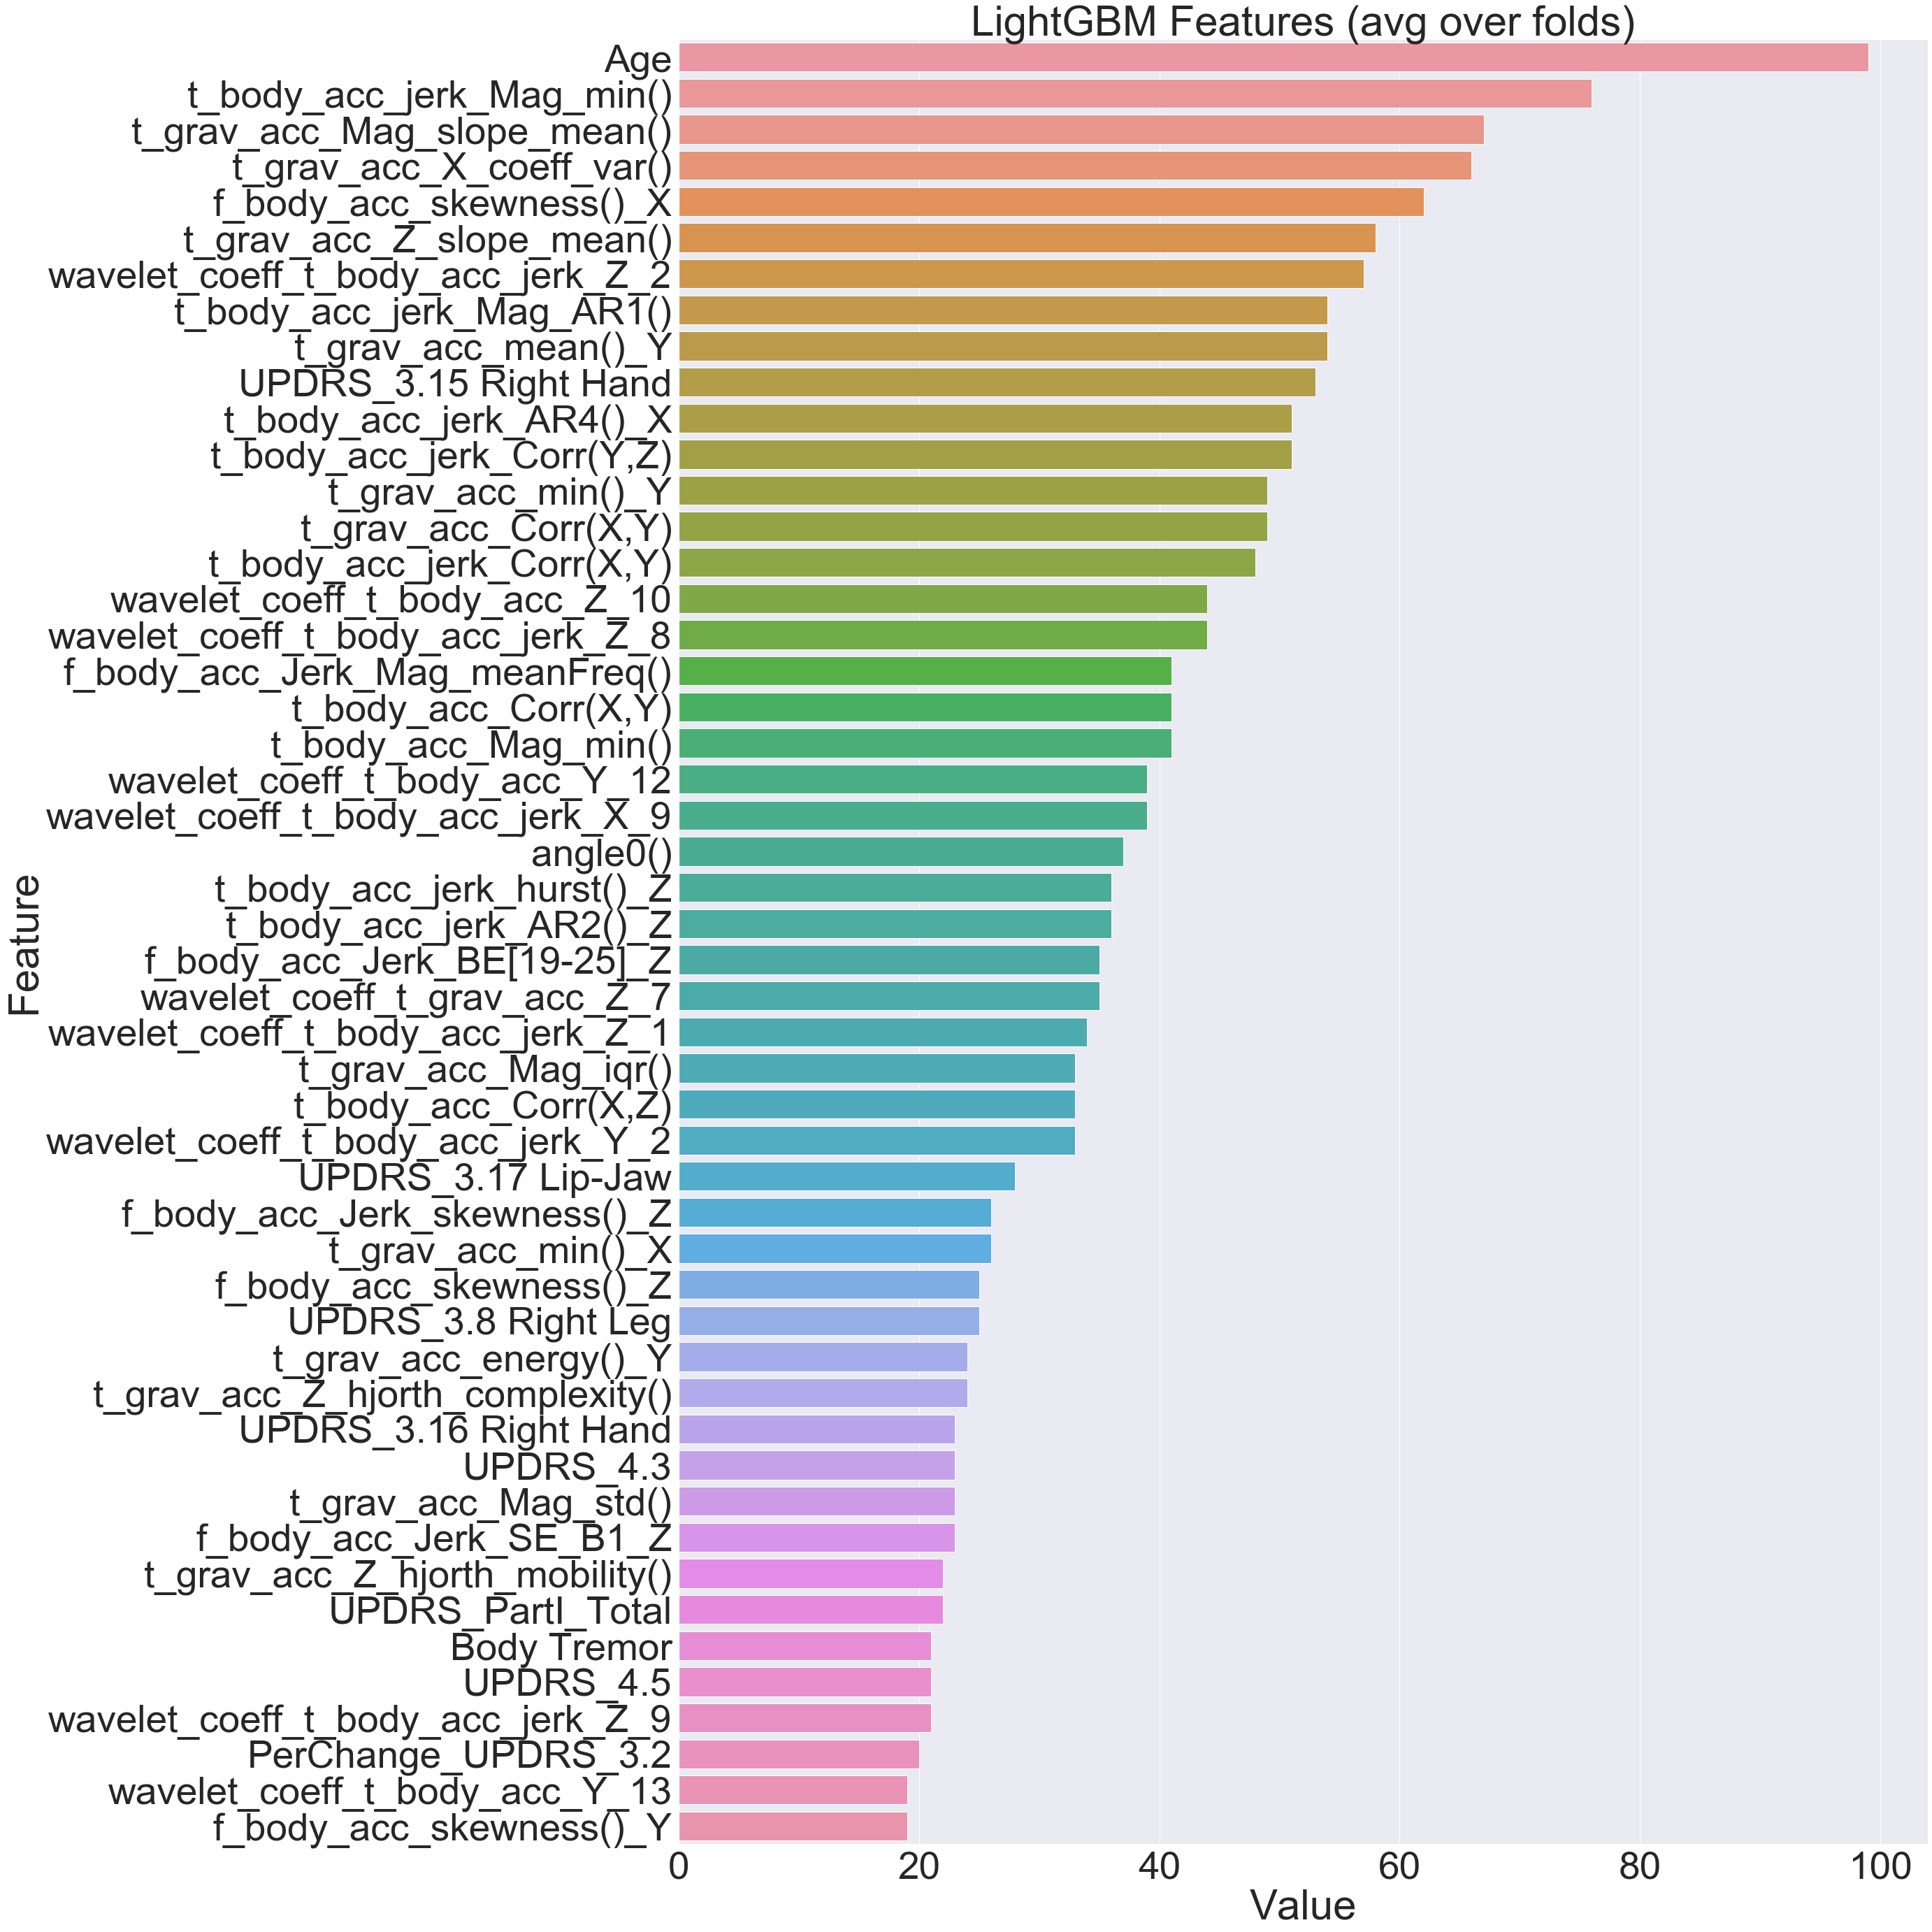

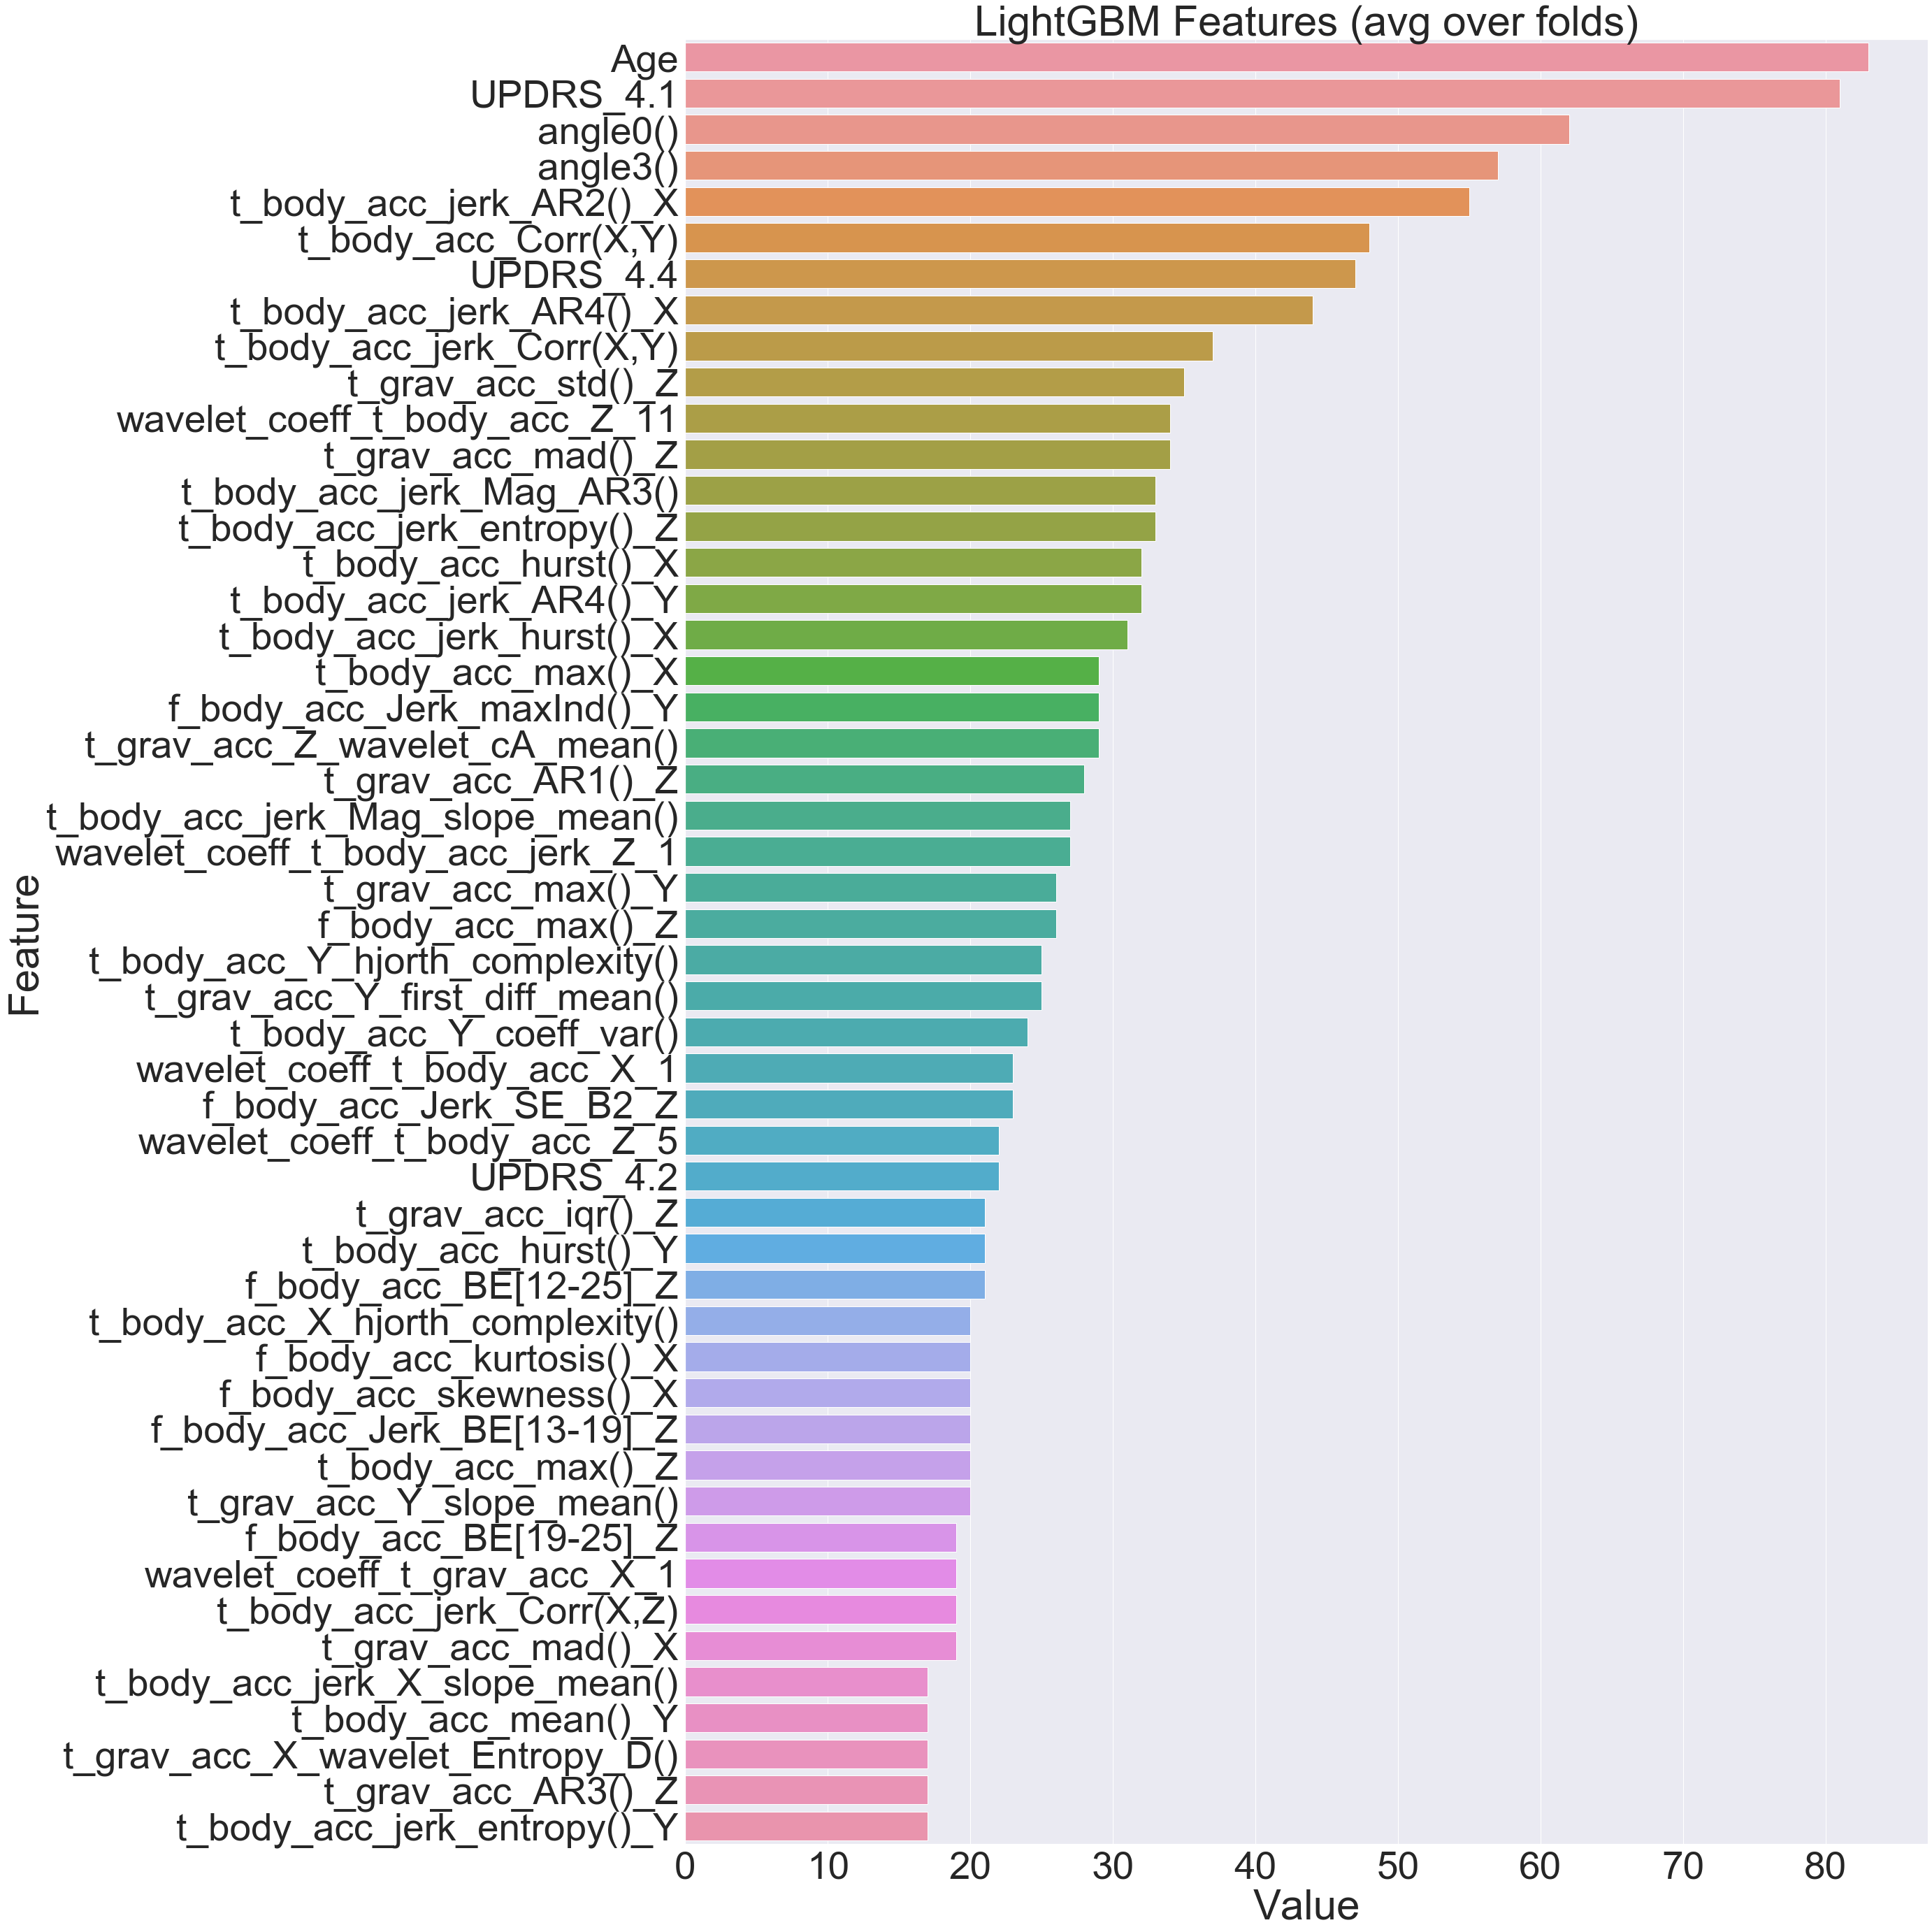

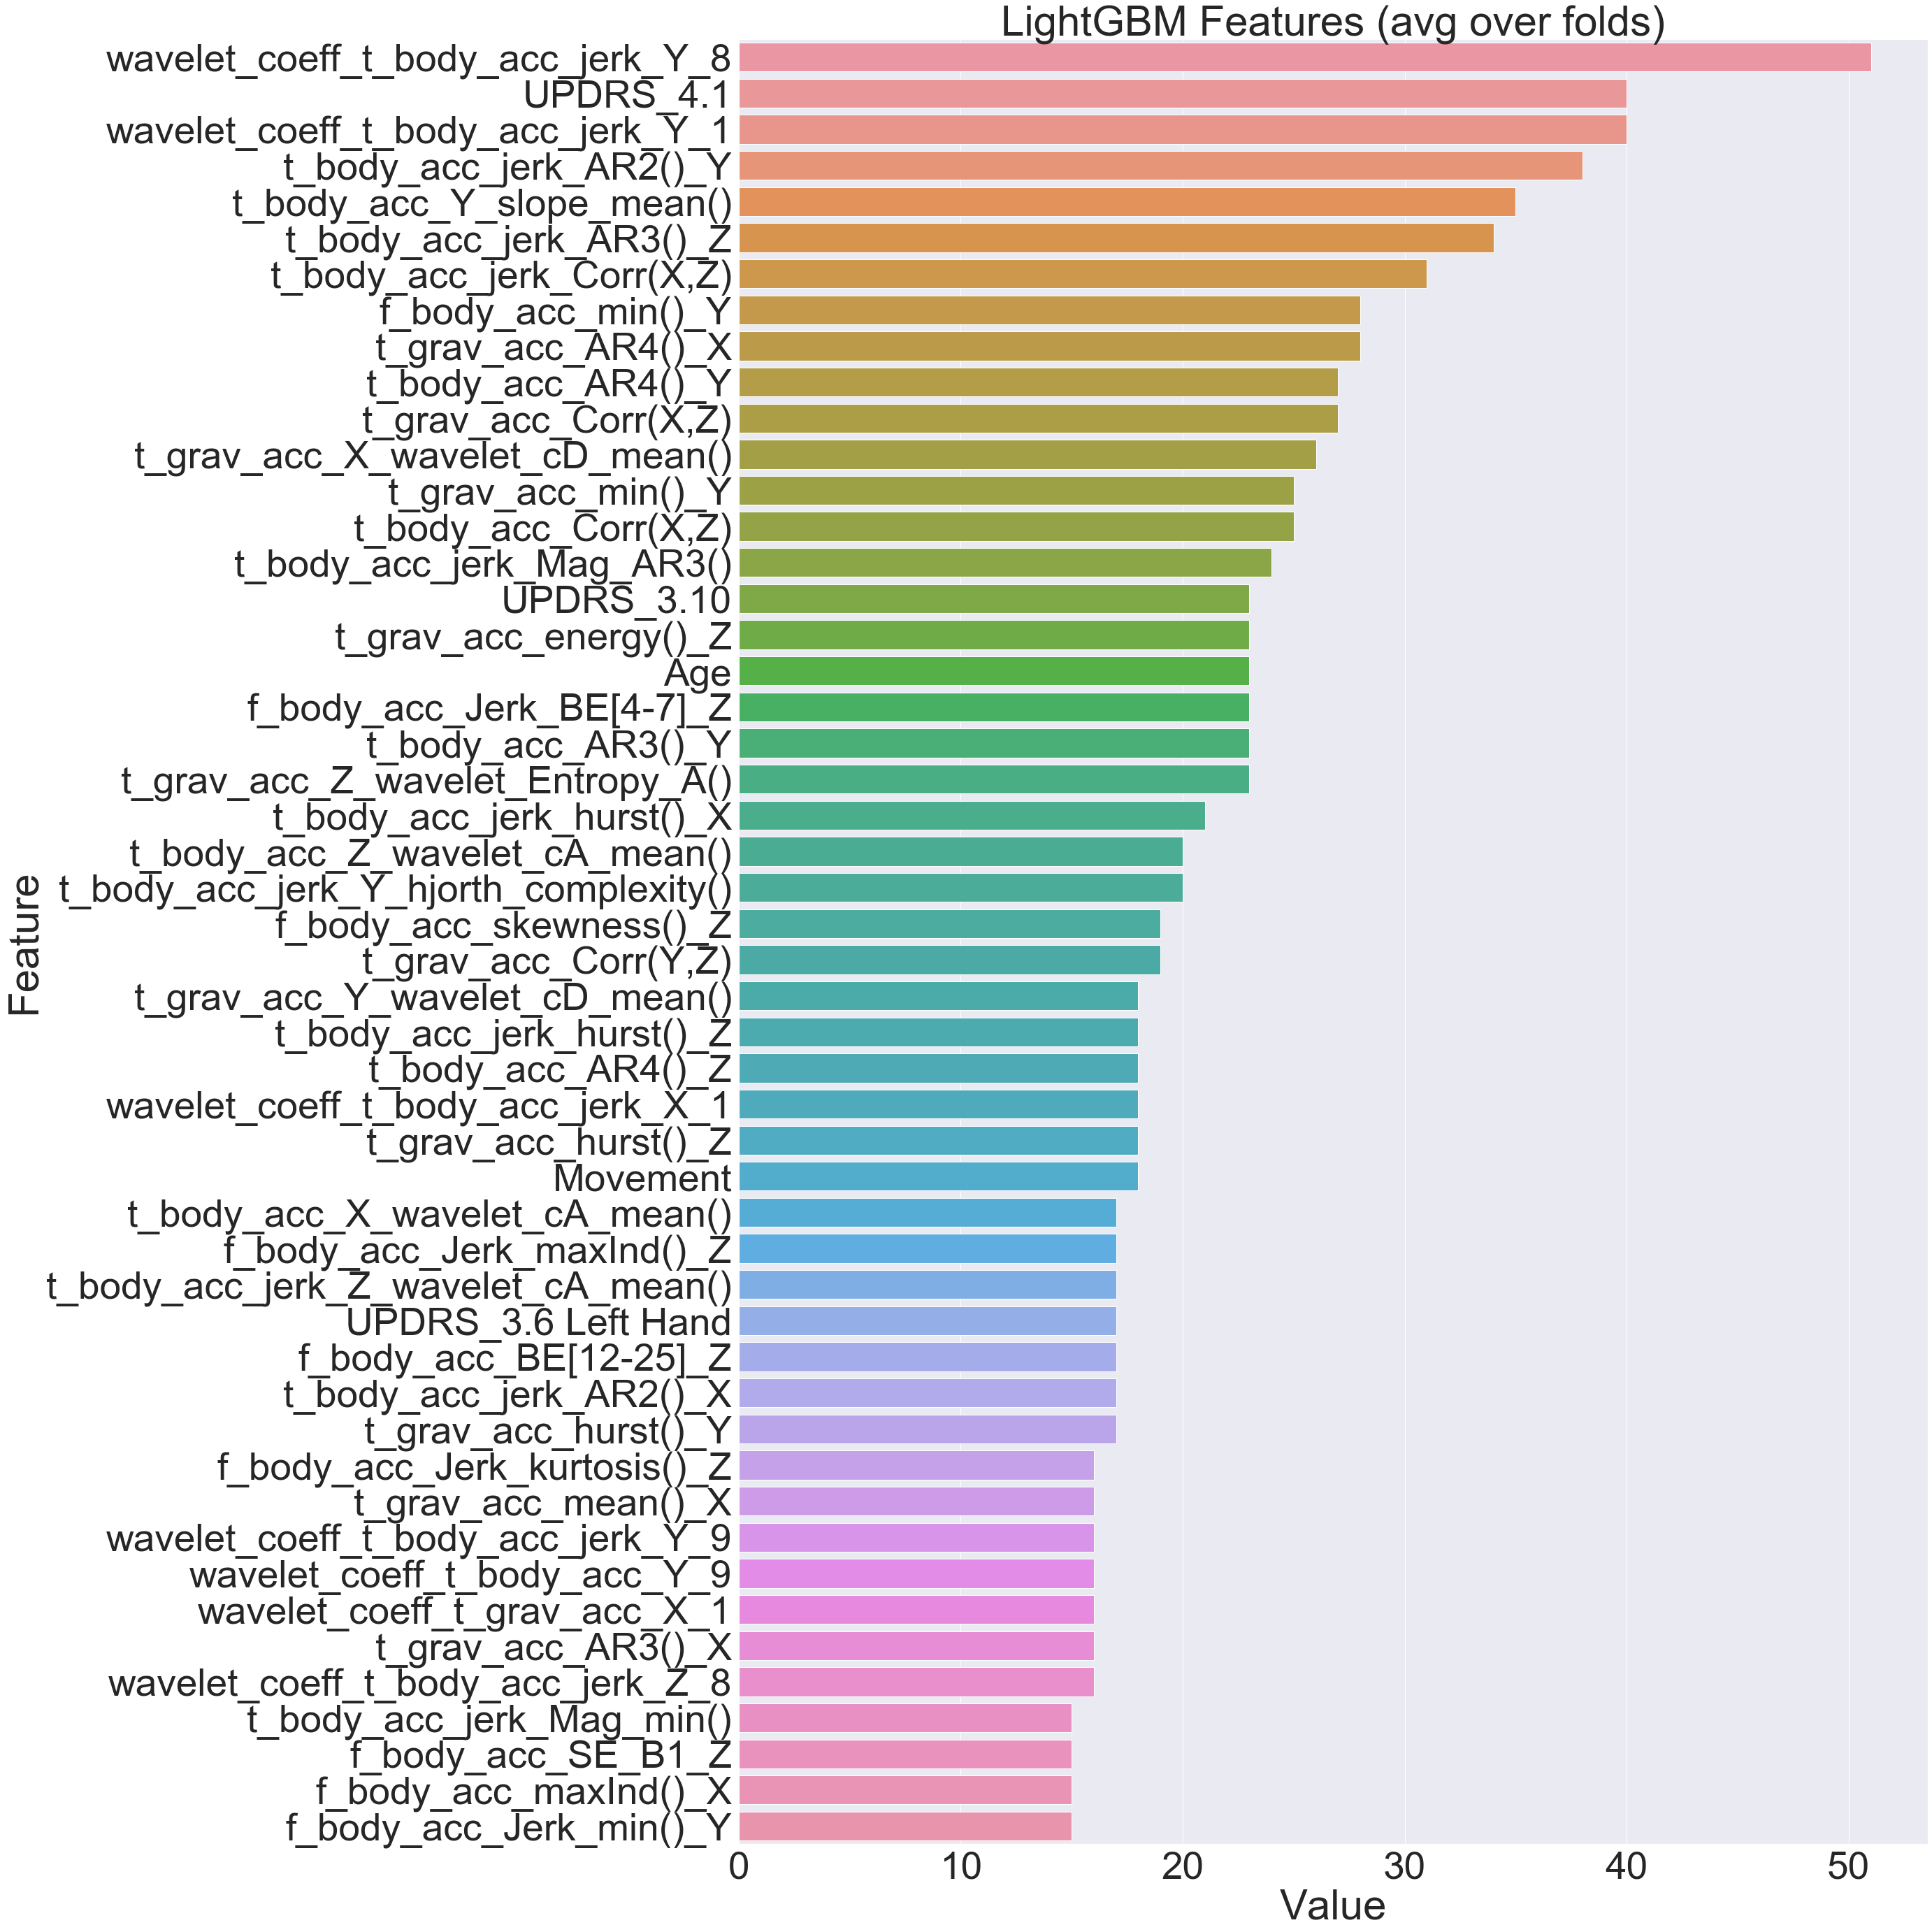

In [164]:
imp1=get_lgbm_varimp(data[feat_tremor_cispd],'tremor', max_vars=50)

imp2=get_lgbm_varimp(data[feat_dyskinesia_cispd],'dyskinesia', max_vars=50)

imp3=get_lgbm_varimp(data[feat_on_off_cispd],'on_off', max_vars=50)

# Real PD

## Clinical Data

In [23]:
realpd_clinical=pd.read_csv('realpd_clinical_preprocessed.csv')
print(realpd_clinical.shape)
realpd_clinical.head()

(22, 93)


subject_id  Age  Gender  smartphone_brand  Most_Common_Smartphone_Location  \
0     hbv002   65       1                 1                                1   
1     hbv012   57       0                 1                                1   
2     hbv013   68       0                 1                                1   
3     hbv014   67       1                 1                                1   
4     hbv016   71       1                 0                                1   

   UPDRS_PartI_Total  UPDRS_PartII_Total  ...  PerChange_UPDRS_3.19A  \
0                  8                  13  ...                    1.0   
1                 11                   4  ...                    0.0   
2                 10                  13  ...                    1.0   
3                  9                  13  ...                    0.0   
4                  7                   8  ...                    0.0   

   PerChange_UPDRS_3.19B  PerChange_UPDRS_3.20  PerChange_Rigidity  \
0                   -0.5                   0.0           -0.272727   
1                    0.0                   0.0           -0.142857   
2                   -0.5                   0.0           -0.384615   
3                    0.0                   0.0           -0.111111   
4                    0.0                   0.0           -0.090909   

   PerChange_Tapping  PerChange_Body Tremor  PerChange_Movement  
0          -0.333333              -0.214286            0.200000  
1          -0.100000              -0.550000           -0.181818  
2          -0.333333              -0.583333           -0.250000  
3          -0.416667              -0.166667            0.000000  
4           0.166667               0.076923            0.090909  

[5 rows x 93 columns]

## till hurst

In [24]:
realpd_1_smartphone=pd.read_csv('analysis2_realpd_comp_training_abhiroop_tillhurst_smartphone.csv')
print(realpd_1_smartphone.shape)
realpd_1_smartwatch=pd.read_csv('analysis2_realpd_comp_training_abhiroop_tillhurst_smartwatch.csv')
print(realpd_1_smartwatch.shape)

(874, 376)
(956, 696)


In [25]:
realpd_1_smartwatch.head()

device_id_acc  t_body_acc_mean()_X  t_body_acc_mean()_Y  \
0          2VSP            -0.000045             0.000026   
1          2WLT             0.000042             0.000079   
2          2ZX3            -0.000001            -0.000010   
3          2WH7            -0.000002             0.000008   
4          2WH7             0.000014            -0.000005   

   t_body_acc_mean()_Z  t_body_acc_std()_X  t_body_acc_std()_Y  \
0            -0.000006            1.093287            1.196446   
1             0.000004            2.437274            2.530655   
2            -0.000031            0.813673            0.904853   
3             0.000059            0.308921            0.336762   
4            -0.000002            0.558929            0.657292   

   t_body_acc_std()_Z  ...  f_body_gyro_Jerk_Mag_skewness()  \
0            1.509475  ...                        57.374883   
1            2.999879  ...                       117.926153   
2            0.768711  ...                        56.176751   
3            0.387006  ...                        35.582949   
4            0.692808  ...                        48.218780   

   f_body_gyro_Jerk_Mag_kurtosis()  angle0()_y  angle1()_y  angle2()_y  \
0                      6181.289833    2.521363    2.155205    1.180774   
1                     17861.628404    1.776384    0.649764    2.362049   
2                      4835.658182    1.595897    1.794558    1.967655   
3                      2662.389466    0.697318    2.913551    2.171902   
4                      4586.099451    0.709405    1.729234    2.190499   

   angle3()_y  angle4()_y  
0    0.733659    2.154569  
1    1.056390    1.044818  
2    2.210951    0.791589  
3    0.908074    0.989416  
4    0.933912    0.981358  

[5 rows x 696 columns]

## Wavelet Features

In [28]:
realpd_2_smartphone=pd.read_csv('realpd_wavelet_features_smartphone_training.csv')
print(realpd_2_smartphone.shape)
realpd_2_smartwatch=pd.read_csv('realpd_wavelet_features_smartwatch_training.csv')
print(realpd_2_smartwatch.shape)

(877, 193)
(963, 322)


In [29]:
realpd_2_smartwatch.head()

device_id_acc  wavelet_coeff_t_body_acc_X_1  wavelet_coeff_t_body_acc_X_2  \
0          2VSP                   -113.258712                   -113.019573   
1          2WLT                   -249.900665                   -252.935250   
2          2ZX3                    -78.992213                    -80.052549   
3          2WH7                    -21.940180                    -22.312575   
4          2WH7                     -8.251838                    -11.045222   

   wavelet_coeff_t_body_acc_X_3  wavelet_coeff_t_body_acc_X_4  \
0                   -116.083608                   -120.742291   
1                   -265.333014                   -283.369728   
2                    -83.272378                    -90.863430   
3                    -23.469052                    -24.400411   
4                    -12.718602                    -18.216305   

   wavelet_coeff_t_body_acc_X_5  wavelet_coeff_t_body_acc_X_6  ...  \
0                   -125.918915                   -131.568461  ...   
1                   -296.963511                   -308.135160  ...   
2                   -100.756648                   -109.653792  ...   
3                    -24.561085                    -24.736420  ...   
4                    -32.211938                    -57.165884  ...   

   wavelet_coeff_t_body_gyro_jerk_mag_10  \
0                              92.716358   
1                             117.760585   
2                              61.189827   
3                              10.170531   
4                              87.638295   

   wavelet_coeff_t_body_gyro_jerk_mag_11  \
0                             731.176554   
1                            1988.714905   
2                             417.398594   
3                             133.059840   
4                             279.266402   

   wavelet_coeff_t_body_gyro_jerk_mag_12  \
0                            1333.844056   
1                            3793.559649   
2                             760.290596   
3                             252.933786   
4                             454.602105   

   wavelet_coeff_t_body_gyro_jerk_mag_13  \
0                            1759.882074   
1                            5123.258104   
2                            1007.966340   
3                             342.453576   
4                             561.516048   

   wavelet_coeff_t_body_gyro_jerk_mag_14  \
0                            2036.045696   
1                            5988.937858   
2                            1173.759975   
3                             405.912929   
4                             617.583142   

   wavelet_coeff_t_body_gyro_jerk_mag_15  \
0                            2147.643574   
1                            6387.202671   
2                            1258.386267   
3                             441.931419   
4                             631.242460   

   wavelet_coeff_t_body_gyro_jerk_mag_16  
0                            2093.034877  
1                            6257.878473  
2                            1240.551904  
3                             439.803617  
4                             588.972126  

[5 rows x 322 columns]

## last set of features

In [30]:
realpd_3_smartphone=pd.read_csv('realpd_comp_training_abhiroop_lastfeatures_smartphone.csv')
print(realpd_3_smartphone.shape)
realpd_3_smartwatch=pd.read_csv('realpd_comp_training_abhiroop_lastfeatures_smartwatch.csv')
print(realpd_3_smartwatch.shape)

(874, 253)
(956, 422)


In [31]:
realpd_3_smartwatch.head()

device_id_acc  t_body_acc_X_katz()  t_body_acc_X_coeff_var()  \
0          2VSP             1.004000             -24121.668930   
1          2WLT             1.020188              58603.225645   
2          2ZX3             1.002798            -545517.997583   
3          2WH7             1.000423            -144341.044526   
4          2WH7             1.001493              39152.736486   

   t_body_acc_X_slope_mean()  t_body_acc_X_slope_std()  \
0                  -0.000043                  0.274105   
1                   0.000753                  0.942833   
2                   0.001156                  0.228635   
3                   0.000079                  0.088970   
4                   0.000002                  0.198279   

   t_body_acc_X_hjorth_activity()  t_body_acc_X_hjorth_mobility()  ...  \
0                        1.195276                        0.322246  ...   
1                        5.940303                        0.402234  ...   
2                        0.662064                        0.373940  ...   
3                        0.095432                        0.330273  ...   
4                        0.312401                        0.415120  ...   

   t_body_gyro_jerk_Mag_wavelet_cA_std()  \
0                              18.883790   
1                              42.222093   
2                              11.835444   
3                               3.971671   
4                               7.491964   

   t_body_gyro_jerk_Mag_wavelet_cA_Energy()  \
0                              1.378725e+07   
1                              1.047006e+08   
2                              5.024339e+06   
3                              5.396218e+05   
4                              2.081187e+06   

   t_body_gyro_jerk_Mag_wavelet_Entropy_A()  \
0                              1.167421e+08   
1                              1.000636e+09   
2                              3.873472e+07   
3                              3.635382e+06   
4                              1.426769e+07   

   t_body_gyro_jerk_Mag_wavelet_cD_mean()  \
0                                0.021184   
1                                0.017429   
2                                0.016609   
3                                0.005732   
4                               -0.008545   

   t_body_gyro_jerk_Mag_wavelet_cD_std()  \
0                               5.664321   
1                              17.923587   
2                               3.842511   
3                               1.463915   
4                               2.772051   

   t_body_gyro_jerk_Mag_wavelet_cD_Energy()  \
0                              9.625816e+05   
1                              9.637979e+06   
2                              4.429698e+05   
3                              6.429668e+04   
4                              2.305455e+05   

   t_body_gyro_jerk_Mag_wavelet_Entropy_D()  
0                              6.456324e+06  
1                              7.701527e+07  
2                              2.659358e+06  
3                              3.512790e+05  
4                              1.182145e+06  

[5 rows x 422 columns]

## Combined Data

### SmartPhone

In [56]:
realpd_smartphone=pd.merge(realpd_1_smartphone,realpd_2_smartphone,on='measurement_id')
realpd_smartphone=pd.merge(realpd_smartphone,realpd_3_smartphone,on='measurement_id')

#columns name change
realpd_smartphone_dummy=realpd_smartphone.copy()
ls=list(realpd_smartphone.columns)
ls.remove('measurement_id')
realpd_smartphone=realpd_smartphone[ls]
realpd_smartphone.columns=[i+'_phone' for i in list(realpd_smartphone[ls].columns)]
realpd_smartphone['measurement_id']=realpd_smartphone_dummy['measurement_id']
print(realpd_smartphone.shape)
realpd_smartphone.head()

(874, 820)


t_body_acc_mean()_X_phone  t_body_acc_mean()_Y_phone  \
0              -4.099065e-07              -4.945145e-07   
1               5.097855e-06              -6.718633e-06   
2              -5.860476e-06               4.557677e-06   
3              -2.010678e-06               3.649900e-06   
4               1.167462e-04               5.815877e-05   

   t_body_acc_mean()_Z_phone  t_body_acc_std()_X_phone  \
0               1.272551e-07                  0.194310   
1              -1.150386e-06                  1.030481   
2               3.055305e-05                  0.377389   
3               1.612748e-06                  0.118161   
4              -1.062504e-04                  0.534147   

   t_body_acc_std()_Y_phone  t_body_acc_std()_Z_phone  \
0                  0.198883                  0.427278   
1                  1.282587                  1.155372   
2                  0.294640                  0.527385   
3                  0.125210                  0.145451   
4                  0.548620                  0.690895   

   t_body_acc_mad()_X_phone  ...  \
0                  0.012449  ...   
1                  0.616868  ...   
2                  0.038554  ...   
3                  0.057362  ...   
4                  0.150960  ...   

   t_body_acc_jerk_Mag_wavelet_cA_Energy()_phone  \
0                                   1.393699e+08   
1                                   3.929567e+08   
2                                   6.388958e+07   
3                                   4.985401e+06   
4                                   2.690837e+07   

   t_body_acc_jerk_Mag_wavelet_Entropy_A()_phone  \
0                                   2.186716e+09   
1                                   4.251168e+09   
2                                   7.231263e+08   
3                                   3.436853e+07   
4                                   2.934527e+08   

   t_body_acc_jerk_Mag_wavelet_cD_mean()_phone  \
0                                    -0.000474   
1                                    -0.001581   
2                                    -0.001341   
3                                    -0.001355   
4                                     0.046870   

   t_body_acc_jerk_Mag_wavelet_cD_std()_phone  \
0                                   22.197886   
1                                   16.295724   
2                                    7.486253   
3                                    1.945919   
4                                   11.206863   

   t_body_acc_jerk_Mag_wavelet_cD_Energy()_phone  \
0                                   2.956526e+07   
1                                   1.593330e+07   
2                                   3.362695e+06   
3                                   2.272000e+05   
4                                   2.598204e+06   

   t_body_acc_jerk_Mag_wavelet_Entropy_D()_phone  \
0                                   4.334669e+08   
1                                   1.424324e+08   
2                                   3.097115e+07   
3                                   1.203258e+06   
4                                   2.343991e+07   

                         measurement_id  
0  05205dc3-9c82-4b6b-921e-b6c2edd2c993  
1  aba31c29-79ef-4221-9412-156538a2fd4e  
2  6cab466b-3c95-4cc0-ba1b-8650f5a12504  
3  27eccfc4-e329-4695-aee8-6d706b247191  
4  ed560c25-e5c5-4dba-82c7-3fc18c248ce4  

[5 rows x 820 columns]

In [38]:
for i in np.arange(50,325,25):
    print(i)
    model_result_realpd(label_realpd(realpd_smartphone),i,0)

50
==============Selected Features==============
lightgbm test_MSE tremor : 0.38
catboost test_MSE tremor : 0.36
Average test_MSE tremor : 0.37

lightgbm test_MSE dyskinesia : 0.112
catboost test_MSE dyskinesia : 0.106
Average test_MSE dyskinesia : 0.109

lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.17
Average test_MSE on_off : 0.169

75
==============Selected Features==============
lightgbm test_MSE tremor : 0.365
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.358

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.106
Average test_MSE dyskinesia : 0.1075

lightgbm test_MSE on_off : 0.173
catboost test_MSE on_off : 0.168
Average test_MSE on_off : 0.17049999999999998

100
==============Selected Features==============
lightgbm test_MSE tremor : 0.361
catboost test_MSE tremor : 0.375
Average test_MSE tremor : 0.368

lightgbm test_MSE dyskinesia : 0.108
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.1075

lightgbm tes

In [39]:
model_result_realpd(label_realpd(realpd_smartphone),150,0)

==============Selected Features==============
lightgbm test_MSE tremor : 0.367
catboost test_MSE tremor : 0.34
Average test_MSE tremor : 0.35350000000000004

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

lightgbm test_MSE on_off : 0.177
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.16849999999999998



In [ ]:
==============Selected Features==============
lightgbm test_MSE tremor : 0.367
catboost test_MSE tremor : 0.34
Average test_MSE tremor : 0.3535

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

lightgbm test_MSE on_off : 0.177
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.1685

#### RFE

In [58]:
rfem_real(label_realpd(realpd_smartphone),'tremor',1,np.arange(200,0,-25))

Label:  tremor

200 selected features
lightgbm test_MSE tremor : 0.398
catboost test_MSE tremor : 0.35
Average test_MSE tremor : 0.374

175 selected features
lightgbm test_MSE tremor : 0.388
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.3695

150 selected features
lightgbm test_MSE tremor : 0.388
catboost test_MSE tremor : 0.363
Average test_MSE tremor : 0.3755

125 selected features
lightgbm test_MSE tremor : 0.397
catboost test_MSE tremor : 0.352
Average test_MSE tremor : 0.3745

100 selected features
lightgbm test_MSE tremor : 0.403
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.377

75 selected features
lightgbm test_MSE tremor : 0.385
catboost test_MSE tremor : 0.359
Average test_MSE tremor : 0.372

50 selected features
lightgbm test_MSE tremor : 0.393
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.3815

25 selected features
lightgbm test_MSE tremor : 0.384
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.377



In [59]:
rfem_real(label_realpd(realpd_smartphone),'dyskinesia',1,np.arange(175,0,-25))

Label:  dyskinesia

175 selected features
lightgbm test_MSE dyskinesia : 0.105
catboost test_MSE dyskinesia : 0.111
Average test_MSE dyskinesia : 0.108

150 selected features
lightgbm test_MSE dyskinesia : 0.107
catboost test_MSE dyskinesia : 0.106
Average test_MSE dyskinesia : 0.1065

125 selected features
lightgbm test_MSE dyskinesia : 0.106
catboost test_MSE dyskinesia : 0.104
Average test_MSE dyskinesia : 0.105

100 selected features
lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

75 selected features
lightgbm test_MSE dyskinesia : 0.115
catboost test_MSE dyskinesia : 0.11
Average test_MSE dyskinesia : 0.1125

50 selected features
lightgbm test_MSE dyskinesia : 0.122
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.11449999999999999

25 selected features
lightgbm test_MSE dyskinesia : 0.119
catboost test_MSE dyskinesia : 0.113
Average test_MSE dyskinesia : 0.11599999999999999



In [57]:
rfem_real(label_realpd(realpd_smartphone),'on_off',1,np.arange(300,75,-25))

Label:  on_off

300 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.163
Average test_MSE on_off : 0.167

275 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.165
Average test_MSE on_off : 0.1665

250 selected features
lightgbm test_MSE on_off : 0.17
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.165

225 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.161
Average test_MSE on_off : 0.166

200 selected features
lightgbm test_MSE on_off : 0.166
catboost test_MSE on_off : 0.161
Average test_MSE on_off : 0.1635

175 selected features
lightgbm test_MSE on_off : 0.165
catboost test_MSE on_off : 0.168
Average test_MSE on_off : 0.1665

150 selected features
lightgbm test_MSE on_off : 0.162
catboost test_MSE on_off : 0.17
Average test_MSE on_off : 0.166

125 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.164

100 selected feat

In [ ]:
#BEST RFE on SmartWatch=============================
175 selected features
lightgbm test_MSE tremor : 0.388
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.3695

125 selected features
lightgbm test_MSE dyskinesia : 0.106
catboost test_MSE dyskinesia : 0.104
Average test_MSE dyskinesia : 0.105

200 selected features
lightgbm test_MSE on_off : 0.166
catboost test_MSE on_off : 0.161
Average test_MSE on_off : 0.1635
    
#BEST Selected Features on SmartWatch===============
lightgbm test_MSE tremor : 0.367
catboost test_MSE tremor : 0.34
Average test_MSE tremor : 0.3535

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

lightgbm test_MSE on_off : 0.177
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.1685

### SmartWatch

In [60]:
realpd_smartwatch=pd.merge(realpd_1_smartwatch,realpd_2_smartwatch,on=['measurement_id','device_id_acc'])
realpd_smartwatch=pd.merge(realpd_smartwatch,realpd_3_smartwatch,on=['measurement_id','device_id_acc'])

#columns name change
realpd_smartwatch_dummy=realpd_smartwatch.copy()
ls=list(realpd_smartwatch.columns)[1:]
ls.remove('measurement_id')
realpd_smartwatch=realpd_smartwatch[ls]
realpd_smartwatch.columns=[i+'_watch' for i in list(realpd_smartwatch[ls].columns)]
realpd_smartwatch[['measurement_id','device_id_acc']]=realpd_smartwatch_dummy[['measurement_id','device_id_acc']]

realpd_smartwatch['device_id_acc'] = preprocessing.LabelEncoder().fit(realpd_smartwatch['device_id_acc']).transform(realpd_smartwatch['device_id_acc'])

print(realpd_smartwatch.shape)
realpd_smartwatch.head()


(956, 1436)


t_body_acc_mean()_X_watch  t_body_acc_mean()_Y_watch  \
0                  -0.000045                   0.000026   
1                   0.000042                   0.000079   
2                  -0.000001                  -0.000010   
3                  -0.000002                   0.000008   
4                   0.000014                  -0.000005   

   t_body_acc_mean()_Z_watch  t_body_acc_std()_X_watch  \
0                  -0.000006                  1.093287   
1                   0.000004                  2.437274   
2                  -0.000031                  0.813673   
3                   0.000059                  0.308921   
4                  -0.000002                  0.558929   

   t_body_acc_std()_Y_watch  t_body_acc_std()_Z_watch  \
0                  1.196446                  1.509475   
1                  2.530655                  2.999879   
2                  0.904853                  0.768711   
3                  0.336762                  0.387006   
4                  0.657292                  0.692808   

   t_body_acc_mad()_X_watch  ...  \
0                  0.316232  ...   
1                  1.697512  ...   
2                  0.104264  ...   
3                  0.077327  ...   
4                  0.144032  ...   

   t_body_gyro_jerk_Mag_wavelet_Entropy_A()_watch  \
0                                    1.167421e+08   
1                                    1.000636e+09   
2                                    3.873472e+07   
3                                    3.635382e+06   
4                                    1.426769e+07   

   t_body_gyro_jerk_Mag_wavelet_cD_mean()_watch  \
0                                      0.021184   
1                                      0.017429   
2                                      0.016609   
3                                      0.005732   
4                                     -0.008545   

   t_body_gyro_jerk_Mag_wavelet_cD_std()_watch  \
0                                     5.664321   
1                                    17.923587   
2                                     3.842511   
3                                     1.463915   
4                                     2.772051   

   t_body_gyro_jerk_Mag_wavelet_cD_Energy()_watch  \
0                                    9.625816e+05   
1                                    9.637979e+06   
2                                    4.429698e+05   
3                                    6.429668e+04   
4                                    2.305455e+05   

   t_body_gyro_jerk_Mag_wavelet_Entropy_D()_watch  \
0                                    6.456324e+06   
1                                    7.701527e+07   
2                                    2.659358e+06   
3                                    3.512790e+05   
4                                    1.182145e+06   

                         measurement_id  device_id_acc  
0  05205dc3-9c82-4b6b-921e-b6c2edd2c993              0  
1  aba31c29-79ef-4221-9412-156538a2fd4e              5  
2  6cab466b-3c95-4cc0-ba1b-8650f5a12504              6  
3  ed560c25-e5c5-4dba-82c7-3fc18c248ce4              3  
4  f96752b5-850e-4a5a-a74a-69ab4893b6aa              3  

[5 rows x 1436 columns]

In [44]:
for i in np.arange(50,325,25):
    print(i)
    model_result_realpd(label_realpd(realpd_smartwatch),i,0)

50
==============Selected Features==============
lightgbm test_MSE tremor : 0.348
catboost test_MSE tremor : 0.301
Average test_MSE tremor : 0.3245

lightgbm test_MSE dyskinesia : 0.132
catboost test_MSE dyskinesia : 0.126
Average test_MSE dyskinesia : 0.129

lightgbm test_MSE on_off : 0.175
catboost test_MSE on_off : 0.165
Average test_MSE on_off : 0.16999999999999998

75
==============Selected Features==============
lightgbm test_MSE tremor : 0.318
catboost test_MSE tremor : 0.284
Average test_MSE tremor : 0.301

lightgbm test_MSE dyskinesia : 0.131
catboost test_MSE dyskinesia : 0.122
Average test_MSE dyskinesia : 0.1265

lightgbm test_MSE on_off : 0.167
catboost test_MSE on_off : 0.158
Average test_MSE on_off : 0.1625

100
==============Selected Features==============
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.2985

lightgbm test_MSE dyskinesia : 0.129
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.1245

lightg

In [46]:
model_result_realpd(label_realpd(realpd_smartwatch),100,0)

==============Selected Features==============
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.2985

lightgbm test_MSE dyskinesia : 0.129
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.1245

lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.166



In [ ]:
==============Selected Features==============
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.2985

lightgbm test_MSE dyskinesia : 0.129
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.1245

lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.166

In [ ]:
#Sub4 results==============================
lightgbm test_MSE tremor : 0.396
catboost test_MSE tremor : 0.405
Average  test_MSE tremor : 0.400
lightgbm test_MSE dyskinesia : 0.13
catboost test_MSE dyskinesia : 0.121
Average  test_MSE dyskinesia : 0.126    
lightgbm test_MSE on_off : 0.165
catboost test_MSE on_off : 0.154
Average  test_MSE on_off : 0.159 

#### RFE

In [61]:
rfem_real(label_realpd(realpd_smartwatch),'tremor',1,np.arange(225,0,-25))

Label:  tremor

225 selected features
lightgbm test_MSE tremor : 0.314
catboost test_MSE tremor : 0.308
Average test_MSE tremor : 0.311

200 selected features
lightgbm test_MSE tremor : 0.32
catboost test_MSE tremor : 0.304
Average test_MSE tremor : 0.312

175 selected features
lightgbm test_MSE tremor : 0.318
catboost test_MSE tremor : 0.312
Average test_MSE tremor : 0.315

150 selected features
lightgbm test_MSE tremor : 0.317
catboost test_MSE tremor : 0.295
Average test_MSE tremor : 0.306

125 selected features
lightgbm test_MSE tremor : 0.32
catboost test_MSE tremor : 0.302
Average test_MSE tremor : 0.311

100 selected features
lightgbm test_MSE tremor : 0.325
catboost test_MSE tremor : 0.3
Average test_MSE tremor : 0.3125

75 selected features
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292

50 selected features
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.292
Average test_MSE tremor : 0.3

25 selected features
li

In [62]:
rfem_real(label_realpd(realpd_smartwatch),'dyskinesia',1,np.arange(225,25,-25))

Label:  dyskinesia

225 selected features
lightgbm test_MSE dyskinesia : 0.124
catboost test_MSE dyskinesia : 0.127
Average test_MSE dyskinesia : 0.1255

200 selected features
lightgbm test_MSE dyskinesia : 0.122
catboost test_MSE dyskinesia : 0.126
Average test_MSE dyskinesia : 0.124

175 selected features
lightgbm test_MSE dyskinesia : 0.126
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.123

150 selected features
lightgbm test_MSE dyskinesia : 0.123
catboost test_MSE dyskinesia : 0.124
Average test_MSE dyskinesia : 0.1235

125 selected features
lightgbm test_MSE dyskinesia : 0.125
catboost test_MSE dyskinesia : 0.121
Average test_MSE dyskinesia : 0.123

100 selected features
lightgbm test_MSE dyskinesia : 0.124
catboost test_MSE dyskinesia : 0.121
Average test_MSE dyskinesia : 0.1225

75 selected features
lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.122
Average test_MSE dyskinesia : 0.125

50 selected features
lightgbm test_MSE dyskinesi

In [63]:
rfem_real(label_realpd(realpd_smartwatch),'on_off',1,np.arange(300,75,-25))

Label:  on_off

300 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.165
Average test_MSE on_off : 0.1665

275 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.159
Average test_MSE on_off : 0.165

250 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.165
Average test_MSE on_off : 0.1665

225 selected features
lightgbm test_MSE on_off : 0.167
catboost test_MSE on_off : 0.163
Average test_MSE on_off : 0.165

200 selected features
lightgbm test_MSE on_off : 0.169
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.1665

175 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.166
Average test_MSE on_off : 0.167

150 selected features
lightgbm test_MSE on_off : 0.17
catboost test_MSE on_off : 0.162
Average test_MSE on_off : 0.166

125 selected features
lightgbm test_MSE on_off : 0.167
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.1655

100 selected 

In [ ]:
#BEST RFE on SmartWatch=============================
75 selected features
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292

100 selected features
lightgbm test_MSE dyskinesia : 0.124
catboost test_MSE dyskinesia : 0.121
Average test_MSE dyskinesia : 0.1225

275 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.159
Average test_MSE on_off : 0.165
    
#BEST Selected Features on SmartWatch===============
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.2985

lightgbm test_MSE dyskinesia : 0.129
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.1245

lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.166

### Both

In [64]:
realpd=pd.merge(realpd_smartphone,realpd_smartwatch,on=['measurement_id'])
print(realpd.shape)
realpd.head()

(749, 2255)


t_body_acc_mean()_X_phone  t_body_acc_mean()_Y_phone  \
0              -4.099065e-07              -4.945145e-07   
1               5.097855e-06              -6.718633e-06   
2              -5.860476e-06               4.557677e-06   
3               1.167462e-04               5.815877e-05   
4              -3.448596e-06              -1.089161e-21   

   t_body_acc_mean()_Z_phone  t_body_acc_std()_X_phone  \
0               1.272551e-07                  0.194310   
1              -1.150386e-06                  1.030481   
2               3.055305e-05                  0.377389   
3              -1.062504e-04                  0.534147   
4               2.286139e-07                  0.306516   

   t_body_acc_std()_Y_phone  t_body_acc_std()_Z_phone  \
0              1.988825e-01                  0.427278   
1              1.282587e+00                  1.155372   
2              2.946401e-01                  0.527385   
3              5.486204e-01                  0.690895   
4              5.716961e-16                  0.171684   

   t_body_acc_mad()_X_phone  ...  \
0                  0.012449  ...   
1                  0.616868  ...   
2                  0.038554  ...   
3                  0.150960  ...   
4                  0.197977  ...   

   t_body_gyro_jerk_Mag_wavelet_cA_Energy()_watch  \
0                                    1.378725e+07   
1                                    1.047006e+08   
2                                    5.024339e+06   
3                                    5.396218e+05   
4                                    2.081187e+06   

   t_body_gyro_jerk_Mag_wavelet_Entropy_A()_watch  \
0                                    1.167421e+08   
1                                    1.000636e+09   
2                                    3.873472e+07   
3                                    3.635382e+06   
4                                    1.426769e+07   

   t_body_gyro_jerk_Mag_wavelet_cD_mean()_watch  \
0                                      0.021184   
1                                      0.017429   
2                                      0.016609   
3                                      0.005732   
4                                     -0.008545   

   t_body_gyro_jerk_Mag_wavelet_cD_std()_watch  \
0                                     5.664321   
1                                    17.923587   
2                                     3.842511   
3                                     1.463915   
4                                     2.772051   

   t_body_gyro_jerk_Mag_wavelet_cD_Energy()_watch  \
0                                    9.625816e+05   
1                                    9.637979e+06   
2                                    4.429698e+05   
3                                    6.429668e+04   
4                                    2.305455e+05   

   t_body_gyro_jerk_Mag_wavelet_Entropy_D()_watch  device_id_acc  
0                                    6.456324e+06              0  
1                                    7.701527e+07              5  
2                                    2.659358e+06              6  
3                                    3.512790e+05              3  
4                                    1.182145e+06              3  

[5 rows x 2255 columns]

#### SelectFromModel

In [51]:
for i in np.arange(50,325,25):
    print(i)
    model_result_realpd(label_realpd(realpd),i,0)

50
==============Selected Features==============
lightgbm test_MSE tremor : 0.408
catboost test_MSE tremor : 0.387
Average test_MSE tremor : 0.39749999999999996

lightgbm test_MSE dyskinesia : 0.134
catboost test_MSE dyskinesia : 0.129
Average test_MSE dyskinesia : 0.1315

lightgbm test_MSE on_off : 0.165
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.1625

75
==============Selected Features==============
lightgbm test_MSE tremor : 0.401
catboost test_MSE tremor : 0.384
Average test_MSE tremor : 0.3925

lightgbm test_MSE dyskinesia : 0.132
catboost test_MSE dyskinesia : 0.13
Average test_MSE dyskinesia : 0.131

lightgbm test_MSE on_off : 0.165
catboost test_MSE on_off : 0.165
Average test_MSE on_off : 0.165

100
==============Selected Features==============
lightgbm test_MSE tremor : 0.386
catboost test_MSE tremor : 0.363
Average test_MSE tremor : 0.3745

lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.132
Average test_MSE dyskinesia : 0.13

lightgbm 

In [52]:
model_result_realpd(label_realpd(realpd),225,0)

==============Selected Features==============
lightgbm test_MSE tremor : 0.371
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.3705

lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.132
Average test_MSE dyskinesia : 0.13

lightgbm test_MSE on_off : 0.163
catboost test_MSE on_off : 0.162
Average test_MSE on_off : 0.1625



In [ ]:
==============Selected Features==============
lightgbm test_MSE tremor : 0.371
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.3705

lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.132
Average test_MSE dyskinesia : 0.13

lightgbm test_MSE on_off : 0.163
catboost test_MSE on_off : 0.162
Average test_MSE on_off : 0.1625
    

#### RFE

In [65]:
rfem_real(label_realpd(realpd),'tremor',1,np.arange(200,0,-25))

Label:  tremor

200 selected features
lightgbm test_MSE tremor : 0.381
catboost test_MSE tremor : 0.369
Average test_MSE tremor : 0.375

175 selected features
lightgbm test_MSE tremor : 0.391
catboost test_MSE tremor : 0.376
Average test_MSE tremor : 0.3835

150 selected features
lightgbm test_MSE tremor : 0.387
catboost test_MSE tremor : 0.352
Average test_MSE tremor : 0.3695

125 selected features
lightgbm test_MSE tremor : 0.391
catboost test_MSE tremor : 0.366
Average test_MSE tremor : 0.3785

100 selected features
lightgbm test_MSE tremor : 0.398
catboost test_MSE tremor : 0.379
Average test_MSE tremor : 0.3885

75 selected features
lightgbm test_MSE tremor : 0.413
catboost test_MSE tremor : 0.387
Average test_MSE tremor : 0.4

50 selected features
lightgbm test_MSE tremor : 0.423
catboost test_MSE tremor : 0.384
Average test_MSE tremor : 0.40349999999999997

25 selected features
lightgbm test_MSE tremor : 0.427
catboost test_MSE tremor : 0.388
Average test_MSE tremor : 0.4075



In [66]:
rfem_real(label_realpd(realpd),'dyskinesia',1,np.arange(200,0,-25))

Label:  dyskinesia

200 selected features
lightgbm test_MSE dyskinesia : 0.145
catboost test_MSE dyskinesia : 0.137
Average test_MSE dyskinesia : 0.14100000000000001

175 selected features
lightgbm test_MSE dyskinesia : 0.15
catboost test_MSE dyskinesia : 0.148
Average test_MSE dyskinesia : 0.149

150 selected features
lightgbm test_MSE dyskinesia : 0.154
catboost test_MSE dyskinesia : 0.145
Average test_MSE dyskinesia : 0.1495

125 selected features
lightgbm test_MSE dyskinesia : 0.156
catboost test_MSE dyskinesia : 0.145
Average test_MSE dyskinesia : 0.1505

100 selected features
lightgbm test_MSE dyskinesia : 0.152
catboost test_MSE dyskinesia : 0.146
Average test_MSE dyskinesia : 0.149

75 selected features
lightgbm test_MSE dyskinesia : 0.153
catboost test_MSE dyskinesia : 0.149
Average test_MSE dyskinesia : 0.151

50 selected features
lightgbm test_MSE dyskinesia : 0.157
catboost test_MSE dyskinesia : 0.146
Average test_MSE dyskinesia : 0.1515

25 selected features
lightgbm test_

In [67]:
rfem_real(label_realpd(realpd),'on_off',1,np.arange(300,75,-25))

Label:  on_off

300 selected features
lightgbm test_MSE on_off : 0.158
catboost test_MSE on_off : 0.161
Average test_MSE on_off : 0.1595

275 selected features
lightgbm test_MSE on_off : 0.157
catboost test_MSE on_off : 0.159
Average test_MSE on_off : 0.158

250 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.167
Average test_MSE on_off : 0.1675

225 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.164

200 selected features
lightgbm test_MSE on_off : 0.159
catboost test_MSE on_off : 0.156
Average test_MSE on_off : 0.1575

175 selected features
lightgbm test_MSE on_off : 0.162
catboost test_MSE on_off : 0.153
Average test_MSE on_off : 0.1575

150 selected features
lightgbm test_MSE on_off : 0.167
catboost test_MSE on_off : 0.163
Average test_MSE on_off : 0.165

125 selected features
lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.17
Average test_MSE on_off : 0.169

100 selected f

In [ ]:
#BEST RFE on realpd=============================
150 selected features
lightgbm test_MSE tremor : 0.387
catboost test_MSE tremor : 0.352
Average test_MSE tremor : 0.3695

175 selected features
lightgbm test_MSE dyskinesia : 0.15
catboost test_MSE dyskinesia : 0.148
Average test_MSE dyskinesia : 0.149

200 selected features
lightgbm test_MSE on_off : 0.159
catboost test_MSE on_off : 0.156
Average test_MSE on_off : 0.1575
    
#BEST Selected Features on realpd===============
lightgbm test_MSE tremor : 0.371
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.3705

lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.132
Average test_MSE dyskinesia : 0.13

lightgbm test_MSE on_off : 0.163
catboost test_MSE on_off : 0.162
Average test_MSE on_off : 0.1625

In [217]:
#Final Result
#SmartPhone=====================================================
#BEST RFE on SmartPhone=============================
175 selected features
lightgbm test_MSE tremor : 0.388
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.3695

125 selected features
lightgbm test_MSE dyskinesia : 0.106
catboost test_MSE dyskinesia : 0.104
Average test_MSE dyskinesia : 0.105 #winner

200 selected features
lightgbm test_MSE on_off : 0.166
catboost test_MSE on_off : 0.161
Average test_MSE on_off : 0.1635
    
#BEST Selected Features on SmartWatch===============
lightgbm test_MSE tremor : 0.367
catboost test_MSE tremor : 0.34
Average test_MSE tremor : 0.3535

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

lightgbm test_MSE on_off : 0.177
catboost test_MSE on_off : 0.16
Average test_MSE on_off : 0.1685


#SmartWatch=====================================================
#BEST RFE on SmartWatch=============================
75 selected features
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292 #winner

100 selected features
lightgbm test_MSE dyskinesia : 0.124
catboost test_MSE dyskinesia : 0.121
Average test_MSE dyskinesia : 0.1225 

275 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.159
Average test_MSE on_off : 0.165
    
#BEST Selected Features on SmartWatch===============
lightgbm test_MSE tremor : 0.308
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.2985

lightgbm test_MSE dyskinesia : 0.129
catboost test_MSE dyskinesia : 0.12
Average test_MSE dyskinesia : 0.1245

lightgbm test_MSE on_off : 0.168
catboost test_MSE on_off : 0.164
Average test_MSE on_off : 0.166

#combined=====================================================
#BEST RFE on realpd=============================
150 selected features
lightgbm test_MSE tremor : 0.387
catboost test_MSE tremor : 0.352
Average test_MSE tremor : 0.3695

175 selected features
lightgbm test_MSE dyskinesia : 0.15
catboost test_MSE dyskinesia : 0.148
Average test_MSE dyskinesia : 0.149

200 selected features
lightgbm test_MSE on_off : 0.159
catboost test_MSE on_off : 0.156
Average test_MSE on_off : 0.1575 #winner
    
#BEST Selected Features on realpd===============
lightgbm test_MSE tremor : 0.371
catboost test_MSE tremor : 0.37
Average test_MSE tremor : 0.3705

lightgbm test_MSE dyskinesia : 0.128
catboost test_MSE dyskinesia : 0.132
Average test_MSE dyskinesia : 0.13

lightgbm test_MSE on_off : 0.163
catboost test_MSE on_off : 0.162
Average test_MSE on_off : 0.1625

(749, 2351)

In [476]:
feat_tremor=rfem2_real(label_realpd(realpd_smartwatch),'tremor',75,1)
feat_dyskinesia=rfem2_real(label_realpd(realpd_smartphone),'dyskinesia',125,1)
feat_on_off=rfem2_real(label_realpd(realpd),'on_off',200,1)

feat_tremor_watch=rfem2_real(label_realpd(realpd_smartwatch),'tremor',75,1)
feat_dyskinesia_watch=rfem2_real(label_realpd(realpd_smartwatch),'dyskinesia',100,1)
feat_on_off_watch=rfem2_real(label_realpd(realpd_smartwatch),'on_off',275,1)

feat_tremor_phone=rfem2_real(label_realpd(realpd_smartphone),'tremor',175,1)
feat_dyskinesia_phone=rfem2_real(label_realpd(realpd_smartphone),'dyskinesia',125,1)
feat_on_off_phone=rfem2_real(label_realpd(realpd_smartphone),'on_off',200,1)

feat_tremor_both=rfem2_real(label_realpd(realpd),'tremor',150,1)
feat_dyskinesia_both=rfem2_real(label_realpd(realpd),'dyskinesia',175,1)
feat_on_off_both=rfem2_real(label_realpd(realpd),'on_off',200,1)

Label:  tremor

75 selected features
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292

Label:  dyskinesia

125 selected features
lightgbm test_MSE dyskinesia : 0.106
catboost test_MSE dyskinesia : 0.104
Average test_MSE dyskinesia : 0.105

Label:  on_off

200 selected features
lightgbm test_MSE on_off : 0.159
catboost test_MSE on_off : 0.156
Average test_MSE on_off : 0.1575

Label:  tremor

75 selected features
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292

Label:  dyskinesia

100 selected features
lightgbm test_MSE dyskinesia : 0.124
catboost test_MSE dyskinesia : 0.121
Average test_MSE dyskinesia : 0.1225

Label:  on_off

275 selected features
lightgbm test_MSE on_off : 0.171
catboost test_MSE on_off : 0.159
Average test_MSE on_off : 0.165

Label:  tremor

175 selected features
lightgbm test_MSE tremor : 0.388
catboost test_MSE tremor : 0.351
Average test_MSE tremor : 0.3695

Label:  

In [ ]:
#Sub4 results==============================
lightgbm test_MSE tremor : 0.396
catboost test_MSE tremor : 0.405
Average  test_MSE tremor : 0.400
lightgbm test_MSE dyskinesia : 0.13
catboost test_MSE dyskinesia : 0.121
Average  test_MSE dyskinesia : 0.126    
lightgbm test_MSE on_off : 0.165
catboost test_MSE on_off : 0.154
Average  test_MSE on_off : 0.159 

### confirmartion of selected features

In [322]:
def model_result_realpd4(df_train,label,rn):
    a=lightgbm_real(df_train,label,rn)
    b=catboost_real(df_train,label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')
    
def model_result_realpd2(df_train,label,num,rn):
    feat=SelectFromModel_lightgbm_realpd(df_train,label,num,rn)
    a=lightgbm_real(df_train[feat],label,rn)
    b=catboost_real(df_train[feat],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')

def model_result_realpd3(df_train,feat,label,rn):
    a=lightgbm_real(df_train[feat],label,rn)
    b=catboost_real(df_train[feat],label,rn)
    print('lightgbm test_MSE '+label+' :',a)
    print('catboost test_MSE '+label+' :',b)
    print('Average test_MSE '+label+' :',(a+b)/2)
    print('')

In [380]:
rn=1
print('================Original Data===============')
model_result_realpd4(label_realpd(realpd_smartwatch),'tremor',rn)
model_result_realpd4(label_realpd(realpd_smartphone),'dyskinesia',rn)
model_result_realpd4(label_realpd(realpd),'on_off',rn)

print('============BestSelectModel Features=========')
model_result_realpd2(label_realpd(realpd_smartwatch),'tremor',200,rn)
model_result_realpd2(label_realpd(realpd_smartphone),'dyskinesia',200,rn)
model_result_realpd2(label_realpd(realpd),'on_off',400,rn)

print('==============RFE Features===================')
model_result_realpd3(label_realpd(realpd_smartwatch),feat_tremor,'tremor',rn)
model_result_realpd3(label_realpd(realpd_smartphone),feat_dyskinesia,'dyskinesia',rn)
model_result_realpd3(label_realpd(realpd),feat_on_off,'on_off',rn)

================Original Data===============
lightgbm test_MSE tremor : 0.304
catboost test_MSE tremor : 0.317
Average test_MSE tremor : 0.3105

lightgbm test_MSE dyskinesia : 0.107
catboost test_MSE dyskinesia : 0.108
Average test_MSE dyskinesia : 0.1075

lightgbm test_MSE on_off : 0.162
catboost test_MSE on_off : 0.175
Average test_MSE on_off : 0.16849999999999998

============BestSelectModel Features=========
lightgbm test_MSE tremor : 0.312
catboost test_MSE tremor : 0.276
Average test_MSE tremor : 0.29400000000000004

lightgbm test_MSE dyskinesia : 0.109
catboost test_MSE dyskinesia : 0.107
Average test_MSE dyskinesia : 0.108

lightgbm test_MSE on_off : 0.17
catboost test_MSE on_off : 0.178
Average test_MSE on_off : 0.174

==============RFE Features===================
lightgbm test_MSE tremor : 0.295
catboost test_MSE tremor : 0.289
Average test_MSE tremor : 0.292

lightgbm test_MSE dyskinesia : 0.106
catboost test_MSE dyskinesia : 0.104
Average test_MSE dyskinesia : 0.105

lightg

### Importance Plot

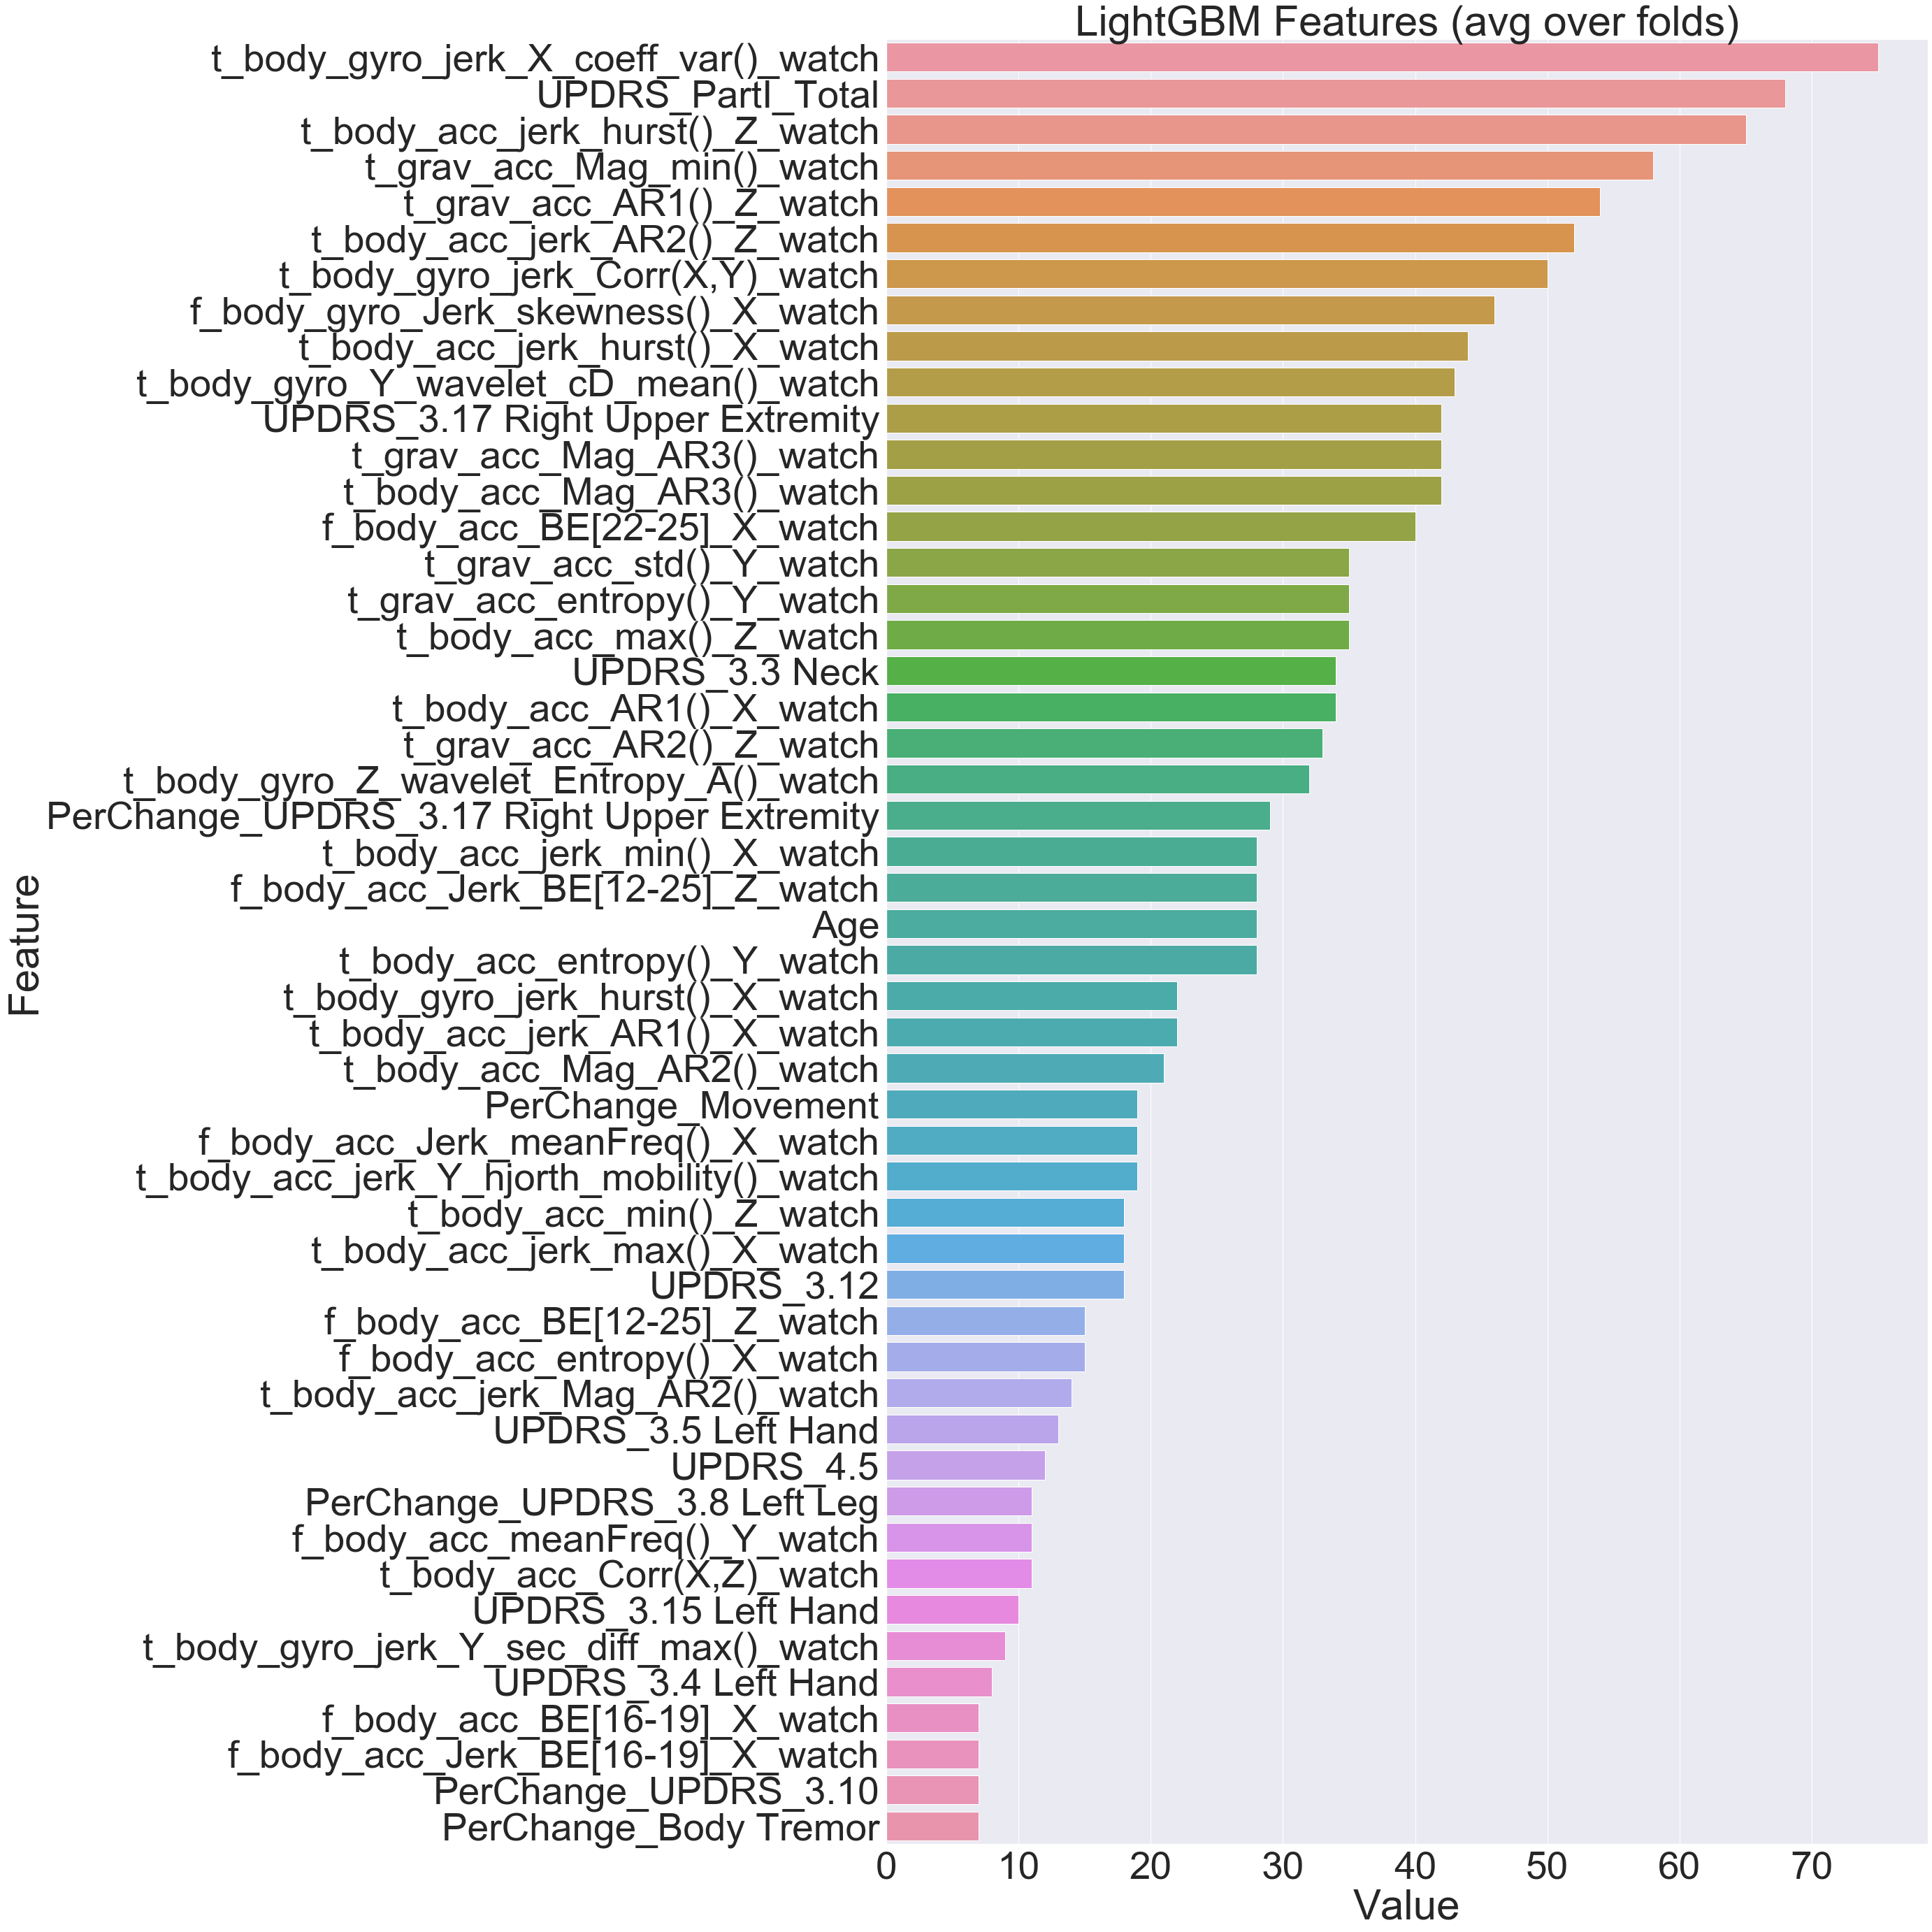

In [97]:
get_lgbm_varimp_realpd(label_realpd(realpd_smartwatch)[feat_tremor],'tremor', max_vars=50)

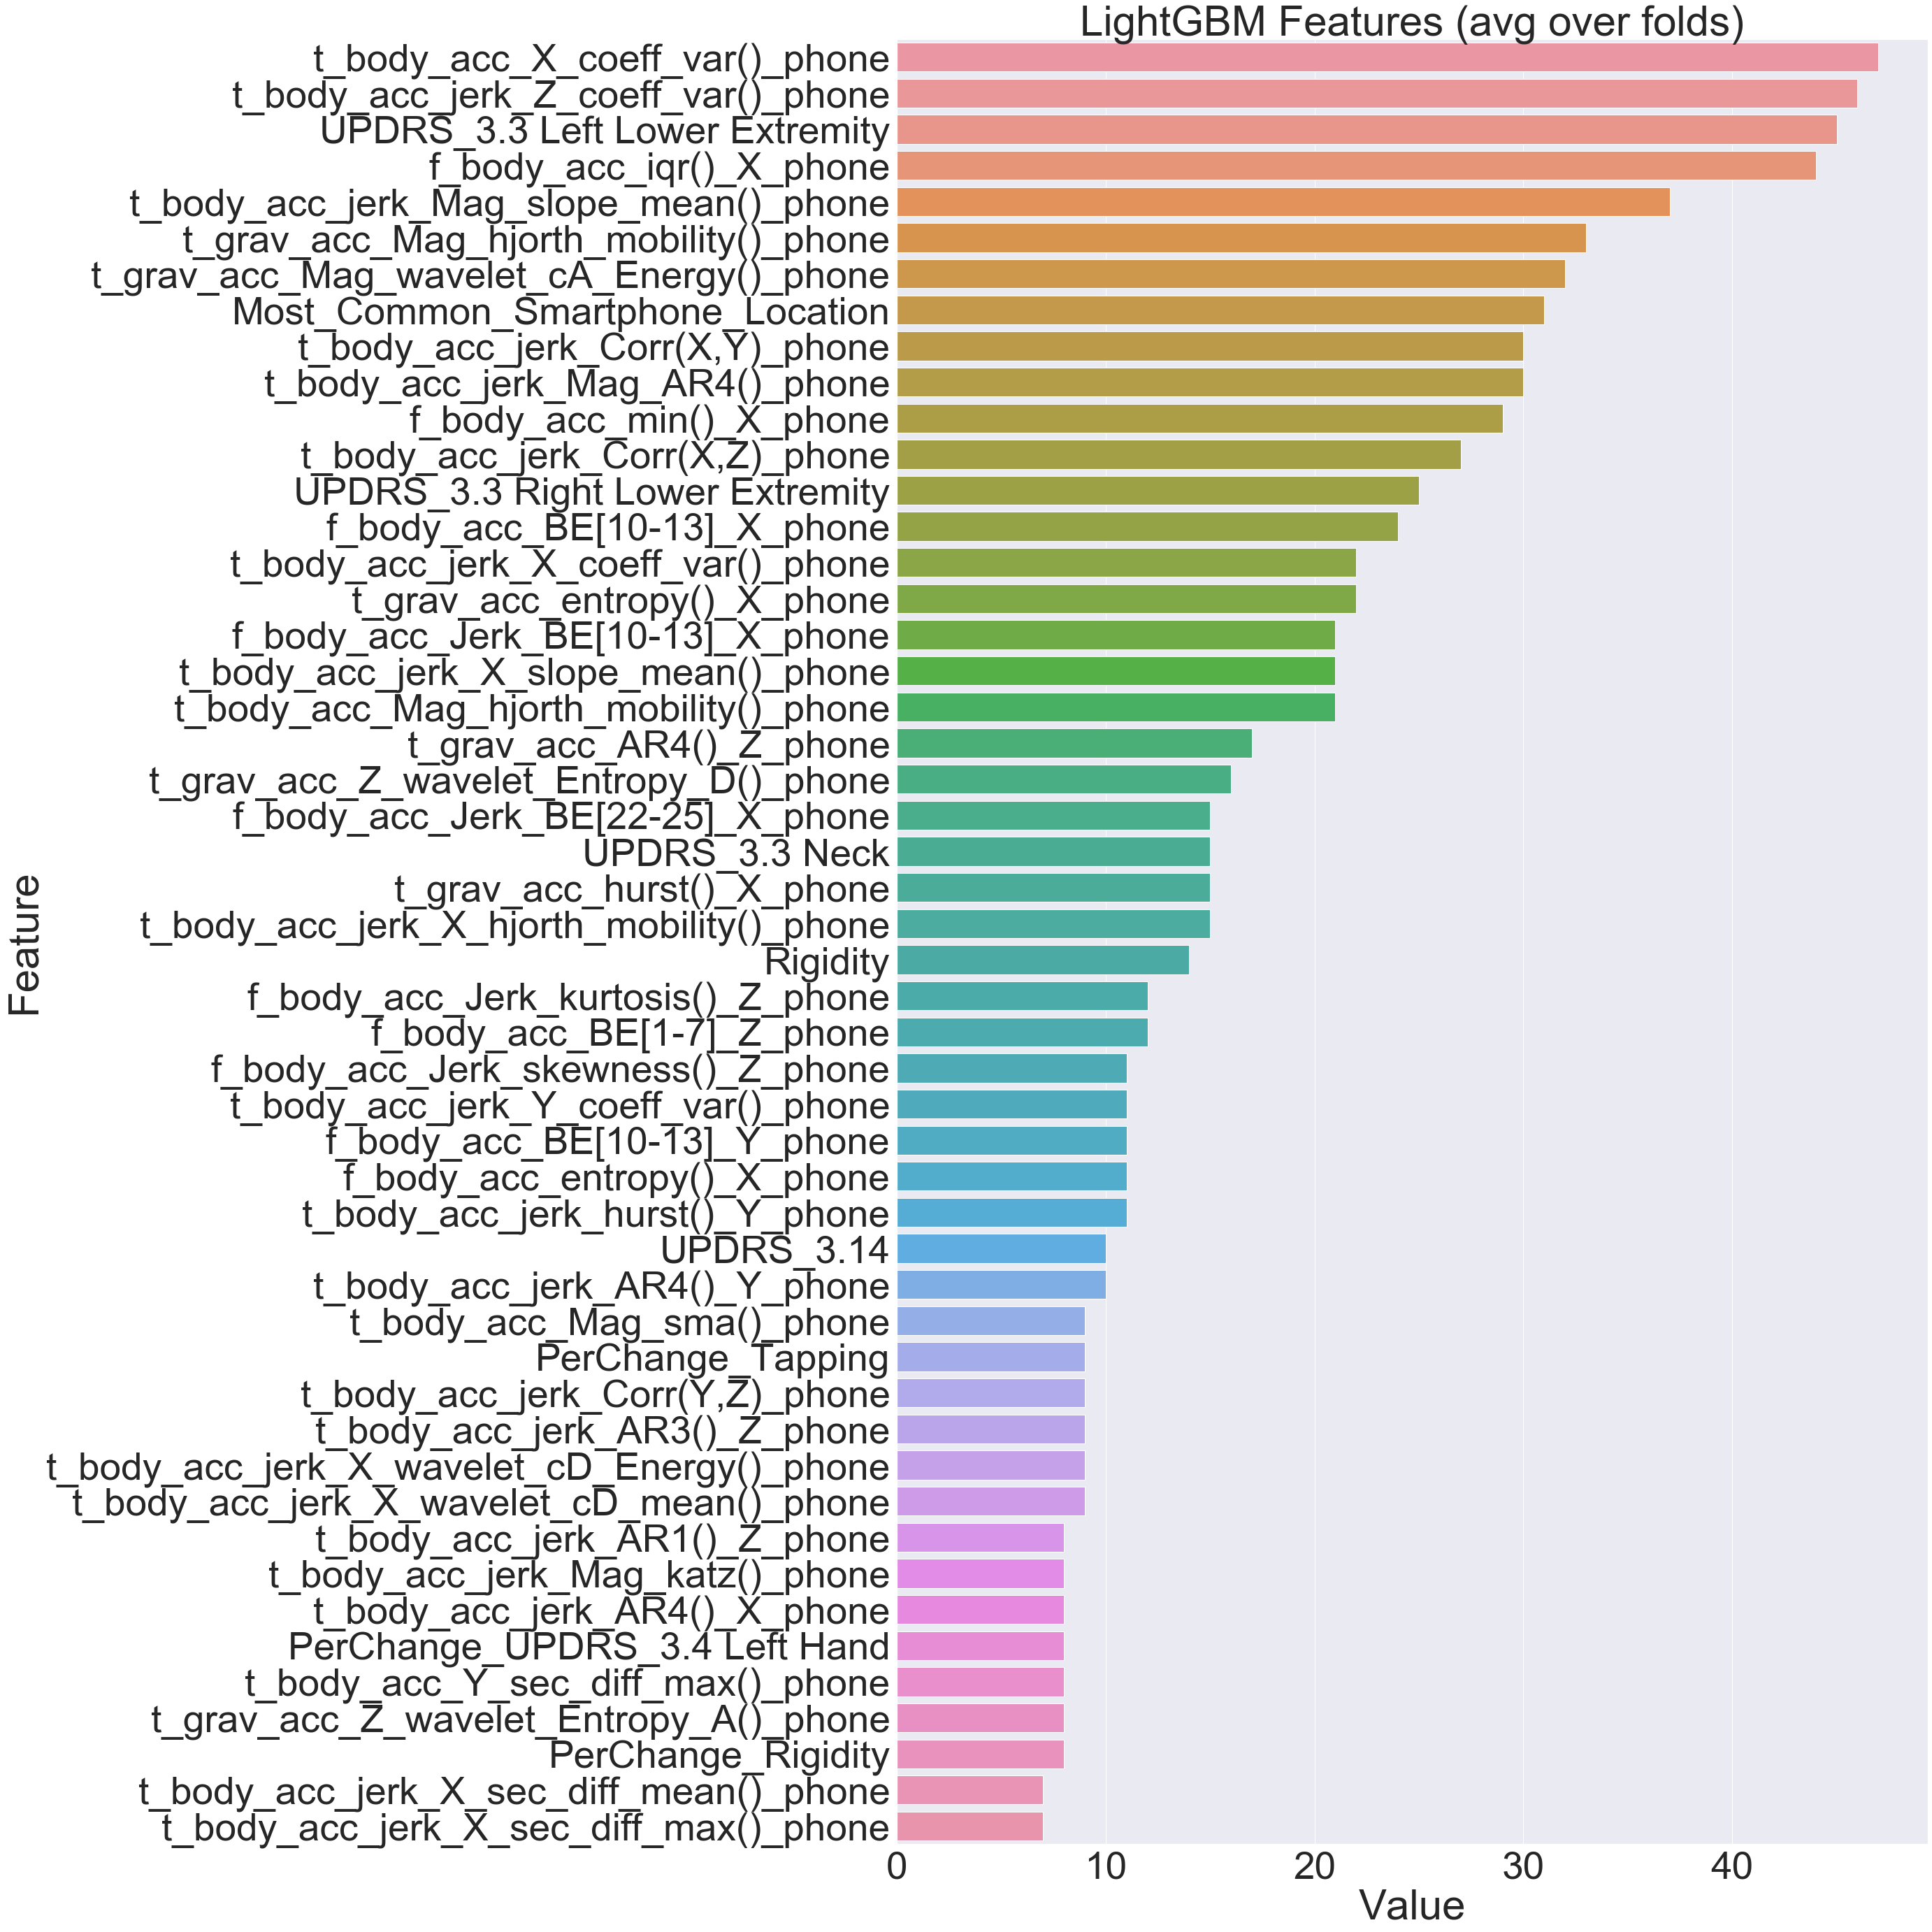

In [98]:
get_lgbm_varimp_realpd(label_realpd(realpd_smartphone)[feat_dyskinesia],'dyskinesia', max_vars=50)

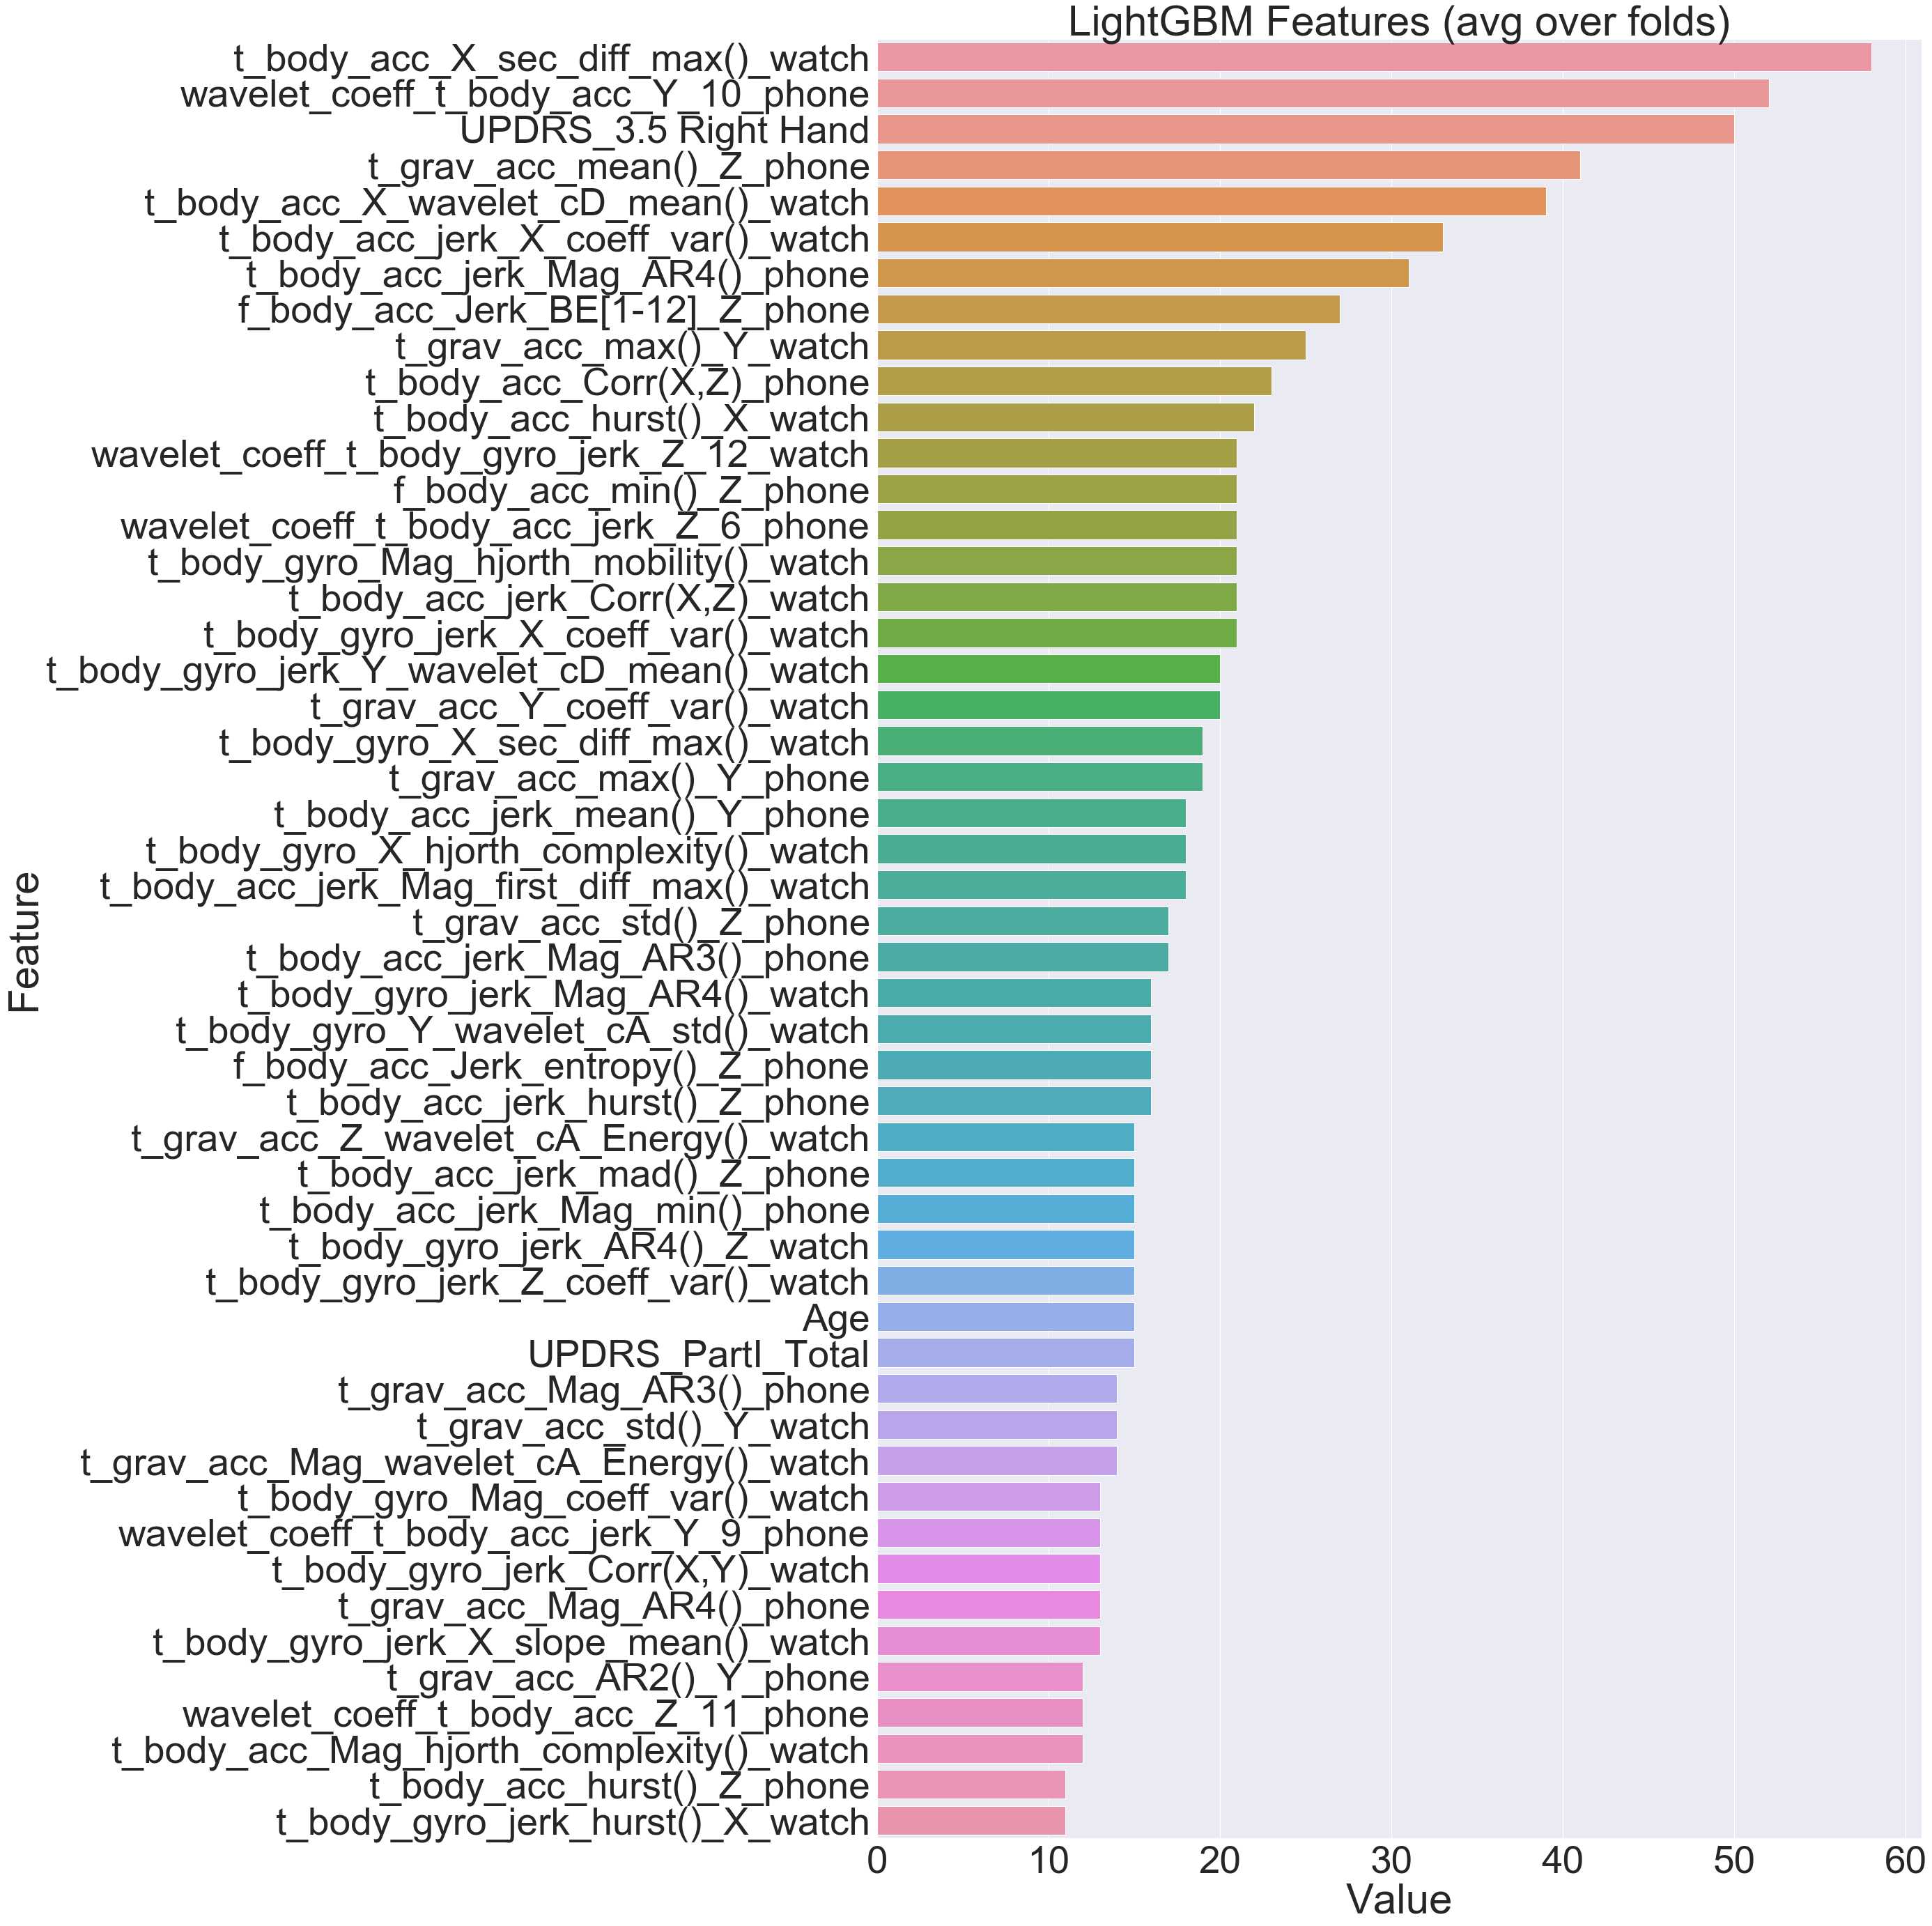

In [99]:
get_lgbm_varimp_realpd(label_realpd(realpd)[feat_on_off],'on_off', max_vars=50)

# Prediction on test data

In [652]:
#CisPD===========================================
def lightgbm_finalpredicion(df4,df4_test,label,feat_fraction):
    train=df4[~df4[label].isnull()].copy()
    test=df4_test.copy()
    x_train=train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1)
    y_train=train[label]
    x_test= test.drop(['subject_id','measurement_id'], axis = 1)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = feat_fraction
    #params['feature_fraction'] = 0.6 cispd, 0.8 realpd
    clf = lgb.train(params, d_train, 150)
    y_pred=clf.predict(x_test)
    return y_pred

#This will give indexes of the categorical features
def categorical_index(df,cols):
    cat=[]
    for c in cols:
        try:
            cat.append(df.columns.get_loc(c))
        except:
            pass # doing nothing on exception
    return cat

def catboost_finalpredicion(df4,df4_test,label):    
    train=df4[~df4[label].isnull()].copy()
    test=df4_test.copy()
    
    X_train=train.drop(['subject_id','measurement_id','on_off','dyskinesia','tremor'], axis = 1)
    y_train=train[label]
    X_test= test.drop(['subject_id','measurement_id'], axis = 1)
    
    train_dataset = Pool(data=X_train,
                         label=y_train,
                         cat_features=categorical_index(X_train,['']))

    eval_dataset = Pool(data=X_test,
                        cat_features=categorical_index(X_train,['']))



    model = CatBoostRegressor(iterations=50, learning_rate=0.1, depth=6,verbose=False)
    # Fit model
    model.fit(train_dataset)
    # Get predictions
    preds = model.predict(eval_dataset)
    return preds

def label_realpd(data):
    label=real_pd_training_id.append(pd.DataFrame(real_pd_ancillary_id), ignore_index=True)
    label=pd.merge(label,realpd_clinical,on='subject_id')
    df_train=pd.merge(label,data,on='measurement_id')
    return(df_train)


## Cis PD

In [653]:
### till hurst
data1_test=pd.read_csv('analysis2_cispd_comp_testing_abhiroop_tillhurst.csv')
print(data1_test.shape)

### Wavelet Features
data2_test=pd.read_csv('cispd_wavelet_testing_features.csv')
print(data2_test.shape)

### Last set of features
data3_test=pd.read_csv('cispd_comp_testing_abhiroop_lastfeatures.csv')
print(data3_test.shape)

### Updated Clinical Features
data4=pd.read_csv('cispd_clinical_preprocessed.csv')

### Combined Features
data_test=pd.merge(data1_test,data2_test,on=['measurement_id'])
data_test=pd.merge(data_test,data3_test,on=['measurement_id'])
data_test=pd.merge(cis_pd_testing_id,data_test,on='measurement_id')
data_test=pd.merge(data_test,data4,on=['subject_id'])
print(data_test.shape)
data_test.head()

(618, 376)
(618, 193)
(618, 253)
(618, 910)


measurement_id  subject_id  t_body_acc_mean()_X  \
0  0e80673b-8c90-474f-8388-00fdf25795e4        1004        -4.532677e-07   
1  a7b61d40-9f26-4878-a2d7-bd766b8ae6f5        1004         6.007693e-06   
2  fc851afd-133c-4e8f-8deb-0079cc442358        1004        -7.692828e-07   
3  90c2c320-1007-47b4-9f8e-cdd37067dfb2        1004        -2.876193e-06   
4  379fd23b-e38f-4214-8a70-7a829004359f        1004        -1.968204e-07   

   t_body_acc_mean()_Y  t_body_acc_mean()_Z  t_body_acc_std()_X  \
0             0.000013         4.614227e-06            0.036979   
1            -0.000006         2.736569e-06            0.226148   
2             0.000003         1.122681e-06            0.101668   
3            -0.000001        -6.146253e-07            0.043764   
4            -0.000005         1.103094e-05            0.050398   

   t_body_acc_std()_Y  ...  PerChange_UPDRS_3.18  PerChange_UPDRS_3.19A  \
0            0.107525  ...                   0.0                    1.0   
1            0.235874  ...                   0.0                    1.0   
2            0.136818  ...                   0.0                    1.0   
3            0.064848  ...                   0.0                    1.0   
4            0.063633  ...                   0.0                    1.0   

   PerChange_UPDRS_3.20  PerChange_Rigidity  PerChange_Tapping  \
0                   0.0                -0.2              -0.25   
1                   0.0                -0.2              -0.25   
2                   0.0                -0.2              -0.25   
3                   0.0                -0.2              -0.25   
4                   0.0                -0.2              -0.25   

   PerChange_Body Tremor  PerChange_Movement  
0              -0.307692                -0.4  
1              -0.307692                -0.4  
2              -0.307692                -0.4  
3              -0.307692                -0.4  
4              -0.307692                -0.4  

[5 rows x 910 columns]

## Realpd

In [689]:
#training smartwatch data
realpd_1_smartwatch_dum=pd.read_csv('analysis2_realpd_comp_training_abhiroop_tillhurst_smartwatch.csv')
realpd_2_smartwatch_dum=pd.read_csv('realpd_wavelet_features_smartwatch_training.csv')
realpd_3_smartwatch_dum=pd.read_csv('realpd_comp_training_abhiroop_lastfeatures_smartwatch.csv')
realpd_smartwatch_dum=pd.merge(realpd_1_smartwatch_dum,realpd_2_smartwatch_dum,on=['measurement_id','device_id_acc'])
realpd_smartwatch_dum=pd.merge(realpd_smartwatch_dum,realpd_3_smartwatch_dum,on=['measurement_id','device_id_acc'])


## Clinical Data
realpd_clinical_test=pd.read_csv('realpd_clinical_preprocessed.csv')
label_test=pd.merge(real_pd_testing_id,realpd_clinical_test,on='subject_id')
print('label: ',label_test.shape)

## till hurst
realpd_1_smartphone_test=pd.read_csv('analysis2_realpd_comp_testing_abhiroop_tillhurst_smartphone.csv')
print('part1_phone: ',realpd_1_smartphone_test.shape)
realpd_1_smartwatch_test=pd.read_csv('analysis2_realpd_comp_testing_abhiroop_tillhurst_smartwatch.csv')
print('part1_watch: ',realpd_1_smartwatch_test.shape)


## Wavelet Features
realpd_2_smartphone_test=pd.read_csv('realpd_wavelet_features_smartphone_testing.csv')
print('part2_phone: ',realpd_2_smartphone_test.shape)
realpd_2_smartwatch_test=pd.read_csv('realpd_wavelet_features_smartwatch_testing.csv')
print('part2_watch: ',realpd_2_smartwatch_test.shape)


## last set of features
realpd_3_smartphone_test=pd.read_csv('realpd_comp_testing_abhiroop_lastfeatures_smartphone.csv')
print('part3_phone: ',realpd_3_smartphone_test.shape)
realpd_3_smartwatch_test=pd.read_csv('realpd_comp_testing_abhiroop_lastfeatures_smartwatch.csv')
print('part3_watch: ',realpd_3_smartwatch_test.shape)


## Combined Data

### SmartPhone
realpd_smartphone_test=pd.merge(realpd_1_smartphone_test,realpd_2_smartphone_test,on='measurement_id')
realpd_smartphone_test=pd.merge(realpd_smartphone_test,realpd_3_smartphone_test,on='measurement_id')

#columns name change
realpd_smartphone_dummy_test=realpd_smartphone_test.copy()
ls=list(realpd_smartphone_test.columns)
ls.remove('measurement_id')
realpd_smartphone_test=realpd_smartphone_test[ls]
realpd_smartphone_test.columns=[i+'_phone' for i in list(realpd_smartphone_test[ls].columns)]
realpd_smartphone_test['measurement_id']=realpd_smartphone_dummy_test['measurement_id']
print('phone: ',realpd_smartphone_test.shape)


### SmartWatch
realpd_smartwatch_test=pd.merge(realpd_1_smartwatch_test,realpd_2_smartwatch_test,on=['measurement_id','device_id_acc'])
realpd_smartwatch_test=pd.merge(realpd_smartwatch_test,realpd_3_smartwatch_test,on=['measurement_id','device_id_acc'])

#columns name change
realpd_smartwatch_dummy_test=realpd_smartwatch_test.copy()
ls=list(realpd_smartwatch_test.columns)[1:]
ls.remove('measurement_id')
realpd_smartwatch_test=realpd_smartwatch_test[ls]
realpd_smartwatch_test.columns=[i+'_watch' for i in list(realpd_smartwatch_test[ls].columns)]
realpd_smartwatch_test[['measurement_id','device_id_acc']]=realpd_smartwatch_dummy_test[['measurement_id','device_id_acc']]
realpd_smartwatch_test['device_id_acc']=preprocessing.LabelEncoder().fit(realpd_smartwatch_dum['device_id_acc']).transform(realpd_smartwatch_test['device_id_acc'])
print('watch: ',realpd_smartwatch_test.shape)


### Both
realpd_test=pd.merge(realpd_smartphone_test,realpd_smartwatch_test,on=['measurement_id'])
print('combined: ',realpd_test.shape)

realpd_smartwatch_test=pd.merge(realpd_smartwatch_test,label_test,on='measurement_id')
realpd_smartphone_test=pd.merge(realpd_smartphone_test,label_test,on='measurement_id')
realpd_test=pd.merge(realpd_test,label_test,on='measurement_id')
print('final_phone: ',realpd_smartphone_test.shape)
print('final_watch: ',realpd_smartwatch_test.shape)
print('final_combined: ',realpd_test.shape)

label:  (191, 94)
part1_phone:  (169, 376)
part1_watch:  (171, 696)
part2_phone:  (169, 193)
part2_watch:  (172, 322)
part3_phone:  (169, 253)
part3_watch:  (171, 422)
phone:  (169, 820)
watch:  (171, 1436)
combined:  (149, 2255)
final_phone:  (169, 913)
final_watch:  (171, 1529)
final_combined:  (149, 2348)


In [690]:
#sub_tremor, sub_dyskinesia, sub_onoff are the templates of a submission
sub4_tremor=pd.read_csv('sub_tremor.csv')
sub4_dyskinesia=pd.read_csv('sub_dyskinesia.csv')
sub4_on_off=pd.read_csv('sub_onoff.csv')

sub_cis=data_test[['measurement_id']].copy()
sub_cis['type']='cispd'
sub_both=realpd_test[['measurement_id']].copy()
sub_both['type2']='both'
sub_watch=realpd_smartwatch_test[['measurement_id']].copy()
sub_watch['type']='watch'
sub_phone=realpd_smartphone_test[['measurement_id']].copy()
sub_phone['type']='phone'

sub = sub_cis.append(pd.DataFrame(data = sub_watch), ignore_index=True)
sub = sub.append(pd.DataFrame(data = sub_phone), ignore_index=True)
sub = pd.merge(sub,sub_both,on='measurement_id',how='left')
sub.loc[~sub.type2.isnull(),'type']='both'
sub=sub.drop('type2',axis=1)
sub=sub.drop_duplicates()

sub4_tremor=pd.merge(sub4_tremor,sub,on='measurement_id',how='left')
sub4_dyskinesia=pd.merge(sub4_dyskinesia,sub,on='measurement_id',how='left')
sub4_on_off=pd.merge(sub4_on_off,sub,on='measurement_id',how='left')

In [691]:
data.shape,data_test.shape

((2210, 913), (618, 910))

In [692]:
#cispd==========================
#cispd_tremor_lgbmpred=lightgbm_finalpredicion(data[feat_tremor_cispd],data_test,'tremor',0.6)
#cispd_dyskinesia_lgbmpred=lightgbm_finalpredicion(data[feat_dyskinesia_cispd],data_test,'dyskinesia',0.6)
#cispd_on_off_lgbmpred=lightgbm_finalpredicion(data[feat_on_off_cispd],data_test,'on_off',0.6)

cispd_tremor_catpred=catboost_finalpredicion(data[feat_tremor_cispd],data_test,'tremor')
cispd_dyskinesia_catpred=catboost_finalpredicion(data[feat_dyskinesia_cispd],data_test,'dyskinesia')
cispd_on_off_catpred=catboost_finalpredicion(data[feat_on_off_cispd],data_test,'on_off')

cispd_tremor=cispd_tremor_catpred
cispd_dyskinesia=cispd_dyskinesia_catpred
cispd_on_off=cispd_on_off_catpred

cispd_pred=pd.DataFrame({'measurement_id':data_test.measurement_id,
             'tremor_cis':cispd_tremor,
             'dyskinesia_cis':cispd_dyskinesia,
             'on_off_cis':cispd_on_off})

In [693]:
#smartwatch=====================
#realpd_tremor_watch_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartwatch)[feat_tremor_watch],realpd_smartwatch_test,'tremor',0.8)
#realpd_dyskinesia_watch_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartwatch)[feat_dyskinesia_watch],realpd_smartwatch_test,'dyskinesia',0.8)
#realpd_on_off_watch_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartwatch)[feat_on_off_watch],realpd_smartwatch_test,'on_off',0.8)

realpd_tremor_watch_catpred=catboost_finalpredicion(label_realpd(realpd_smartwatch)[feat_tremor_watch],realpd_smartwatch_test,'tremor')
realpd_dyskinesia_watch_catpred=catboost_finalpredicion(label_realpd(realpd_smartwatch)[feat_dyskinesia_watch],realpd_smartwatch_test,'dyskinesia')
realpd_on_off_watch_catpred=catboost_finalpredicion(label_realpd(realpd_smartwatch)[feat_on_off_watch],realpd_smartwatch_test,'on_off')

realpd_tremor_watch=realpd_tremor_watch_catpred
realpd_dyskinesia_watch=realpd_dyskinesia_watch_catpred
realpd_on_off_watch=realpd_on_off_watch_catpred

#smartphone=======================
#realpd_tremor_phone_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartphone)[feat_tremor_phone],realpd_smartphone_test,'tremor',0.8)
#realpd_dyskinesia_phone_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartphone)[feat_dyskinesia_phone],realpd_smartphone_test,'dyskinesia',0.8)
#realpd_on_off_phone_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd_smartphone)[feat_on_off_phone],realpd_smartphone_test,'on_off',0.8)

realpd_tremor_phone_catpred=catboost_finalpredicion(label_realpd(realpd_smartphone)[feat_tremor_phone],realpd_smartphone_test,'tremor')
realpd_dyskinesia_phone_catpred=catboost_finalpredicion(label_realpd(realpd_smartphone)[feat_dyskinesia_phone],realpd_smartphone_test,'dyskinesia')
realpd_on_off_phone_catpred=catboost_finalpredicion(label_realpd(realpd_smartphone)[feat_on_off_phone],realpd_smartphone_test,'on_off')

realpd_tremor_phone=realpd_tremor_phone_catpred
realpd_dyskinesia_phone=realpd_dyskinesia_phone_catpred
realpd_on_off_phone=realpd_on_off_phone_catpred



#both=======================
#realpd_tremor_both_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd)[feat_tremor_both],realpd_test,'tremor',0.8)
#realpd_dyskinesia_both_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd)[feat_dyskinesia_both],realpd_test,'dyskinesia',0.8)
#realpd_on_off_both_lgbmpred=lightgbm_finalpredicion(label_realpd(realpd)[feat_on_off_both],realpd_test,'on_off',0.8)

realpd_tremor_both_catpred=catboost_finalpredicion(label_realpd(realpd)[feat_tremor_both],realpd_test,'tremor')
realpd_dyskinesia_both_catpred=catboost_finalpredicion(label_realpd(realpd)[feat_dyskinesia_both],realpd_test,'dyskinesia')
realpd_on_off_both_catpred=catboost_finalpredicion(label_realpd(realpd)[feat_on_off_both],realpd_test,'on_off')

realpd_tremor_both=realpd_tremor_both_catpred
realpd_dyskinesia_both=realpd_dyskinesia_both_catpred
realpd_on_off_both=realpd_on_off_both_catpred

In [694]:
watch_pred=pd.DataFrame({'measurement_id':realpd_smartwatch_test.measurement_id,
             'tremor_watch':realpd_tremor_watch,
             'dyskinesia_watch':realpd_dyskinesia_watch,
             'on_off_watch':realpd_on_off_watch})

phone_pred=pd.DataFrame({'measurement_id':realpd_smartphone_test.measurement_id,
             'tremor_phone':realpd_tremor_phone,
             'dyskinesia_phone':realpd_dyskinesia_phone,
             'on_off_phone':realpd_on_off_phone})

both_pred=pd.DataFrame({'measurement_id':realpd_test.measurement_id,
             'tremor_both':realpd_tremor_both,
             'dyskinesia_both':realpd_dyskinesia_both,
             'on_off_both':realpd_on_off_both})


In [695]:
final_tremor=pd.merge(sub4_tremor,cispd_pred,on='measurement_id',how='left')
final_tremor=pd.merge(final_tremor,watch_pred,on='measurement_id',how='left')
final_tremor=pd.merge(final_tremor,phone_pred,on='measurement_id',how='left')
final_tremor=pd.merge(final_tremor,both_pred,on='measurement_id',how='left')
final_tremor['prediction2']=np.nan

final_dyskinesia=pd.merge(sub4_dyskinesia,cispd_pred,on='measurement_id',how='left')
final_dyskinesia=pd.merge(final_dyskinesia,watch_pred,on='measurement_id',how='left')
final_dyskinesia=pd.merge(final_dyskinesia,phone_pred,on='measurement_id',how='left')
final_dyskinesia=pd.merge(final_dyskinesia,both_pred,on='measurement_id',how='left')
final_dyskinesia['prediction2']=np.nan

final_on_off=pd.merge(sub4_on_off,cispd_pred,on='measurement_id',how='left')
final_on_off=pd.merge(final_on_off,watch_pred,on='measurement_id',how='left')
final_on_off=pd.merge(final_on_off,phone_pred,on='measurement_id',how='left')
final_on_off=pd.merge(final_on_off,both_pred,on='measurement_id',how='left')
final_on_off['prediction2']=np.nan

In [696]:
pd.set_option('display.max_rows', 1000)

In [697]:
final_tremor['prediction2']=np.where(final_tremor.type=='cispd',final_tremor.tremor_cis,
        np.where(final_tremor.type=='phone',final_tremor.tremor_phone,final_tremor.tremor_watch))

final_tremor=final_tremor[['measurement_id','type','prediction2','prediction']]

final_dyskinesia['prediction2']=np.where(final_dyskinesia.type=='cispd',final_dyskinesia.dyskinesia_cis,
        np.where(final_dyskinesia.type=='watch',final_dyskinesia.dyskinesia_watch,final_dyskinesia.dyskinesia_phone))

final_dyskinesia=final_dyskinesia[['measurement_id','type','prediction2','prediction']]

final_on_off['prediction2']=np.where(final_on_off.type=='cispd',final_on_off.on_off_cis,
        np.where(final_on_off.type=='both',final_on_off.on_off_both,
                 np.where(final_on_off.type=='watch',final_on_off.on_off_watch,final_on_off.on_off_phone)))

final_on_off=final_on_off[['measurement_id','type','prediction2','prediction']]

In [700]:
final_tremor=final_tremor[['measurement_id','prediction2']]
final_tremor.columns=['measurement_id','prediction']
final_tremor.prediction=np.where(final_tremor.prediction<=0,0,final_tremor.prediction)

final_dyskinesia=final_dyskinesia[['measurement_id','prediction2']]
final_dyskinesia.columns=['measurement_id','prediction']
final_dyskinesia.prediction=np.where(final_dyskinesia.prediction<=0,0,final_dyskinesia.prediction)

final_on_off=final_on_off[['measurement_id','prediction2']]
final_on_off.columns=['measurement_id','prediction']
final_on_off.prediction=np.where(final_on_off.prediction<=0,0,final_on_off.prediction)

In [704]:
final_tremor.shape,final_dyskinesia.shape,final_on_off.shape

((588, 2), (482, 2), (695, 2))

In [705]:
final_tremor.to_csv('final_tremor.csv',index=False)
final_dyskinesia.to_csv('final_dyskinesia.csv',index=False)
final_on_off.to_csv('final_on_off.csv',index=False)